# Attempt warm start pre-training of CU prediction tasks

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G classification data

In [3]:
check_df = pd.read_csv(f'data/highCu_cls_splits/cv0_train.tsv',sep='\t')
seq_len = len(check_df['upstream_region'].values[0])
check_df.head()

og_index      locus_tag                                    upstream_region  \
0       668  EQU24_RS03640  CAATTGCTGAGTTACATGGATGTAATGAATGCAGAAAATACAGGAG...   
1       706  EQU24_RS03830  GATTTGCGTAAAGCTAAGCCGAGTGCCGCGAAAGGTGTTTATATGA...   
2       710  EQU24_RS03850  CTATCATGAGCAAAGAAGAAAACGACGCAACAAAGAAATAGAAGTT...   
3       756  EQU24_RS04080  ATCGAGCCACCGAACCCCCTTCCAGAAGTTGTCGAAGTTATTTCAT...   
4       789  EQU24_RS04255  AGGAAGCTGGAGCTTCCGGGGTGTCTTTCCCAAGCTGGAGCTTGGG...   

       uMax  lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  \
0  1.243148           1.052587  0.832082 -1.547966   0.0  1.280822  1.084277   
1  1.042152           0.982020  0.041436 -1.268396   0.0  1.172465  0.788694   
2  0.288425          -0.005089 -0.685868 -2.000937   0.0  0.660665  0.754083   
3  0.696524           0.167099  0.017540 -0.952773   0.0  0.504812  0.636391   
4  0.426234           0.064453 -0.294702 -1.166528   0.0  0.976434  0.785287   

   ...    aa3_KO  crotonic_acid  CH4_500ppm  CH4_1000ppm  gene  \
0  ...  0.277148      -0.965229   -0.300738    -0.183536   NaN   
1  ... -0.554703       1.127968   -2.155047    -1.870994  rplJ   
2  ... -0.746728      -0.277687   -3.184635    -3.243279  rpsL   
3  ...  0.396319       0.977263    0.621202     0.693023   NaN   
4  ... -1.244025      -0.781154   -1.353288    -1.615418  rpmE   

                      product  type  highCu_reg_UD  \
0        hypothetical protein   CDS              2   
1   50S ribosomal protein L10   CDS              2   
2   30S ribosomal protein S12   CDS              2   
3  2-isopropylmalate synthase   CDS              2   
4   50S ribosomal protein L31   CDS              2   

                                        shuffled_seq    set  
0  TGAGTGATACTTGAACATTCCTTCTCAGCAGATTCTATATTAATAT...  train  
1  TTAATCAACTGCTGAATAAAGCTCAGGTAGAATGAATAGTGGATGC...  train  
2  CTAAACGGATTAAACTACGCGCTTGGATTAGGGGAAATGCCTTGAT...  train  
3  ATTCCATCTAATCACTTGCCTCTTATTTTCCTATCGTATTATCTAA...  train  
4  ACTTGTTGTAACCTGTCAGTACGGATGCCTCTCAATCTCTGAAATA...  train  

[5 rows x 26 columns]

# Warm start model from saved state dict

### load 5org classification model and confirm predictions on it's own data look correct


In [4]:
m_args_5org_cls = (seq_len,5)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

saved_5org_cls_filename = 'saved_models/5org_cls_cv0_model_state_dict.pt'
model_5org_cls = m.DNA_2CNN_2FC(*m_args_5org_cls,**m_kwargs)
model_5org_cls.load_state_dict(torch.load(saved_5org_cls_filename))
model_5org_cls


DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=5, bias=True)
  )
)

Running predictions for reloaded model_5org_cls


model_name  split  mac_precision  mac_recall    mac_f1  \
0  reloaded model_5org_cls  train       0.965631    0.965722  0.965618   
1  reloaded model_5org_cls   test       0.855052    0.851865  0.853281   

   support  
0    15399  
1     3850

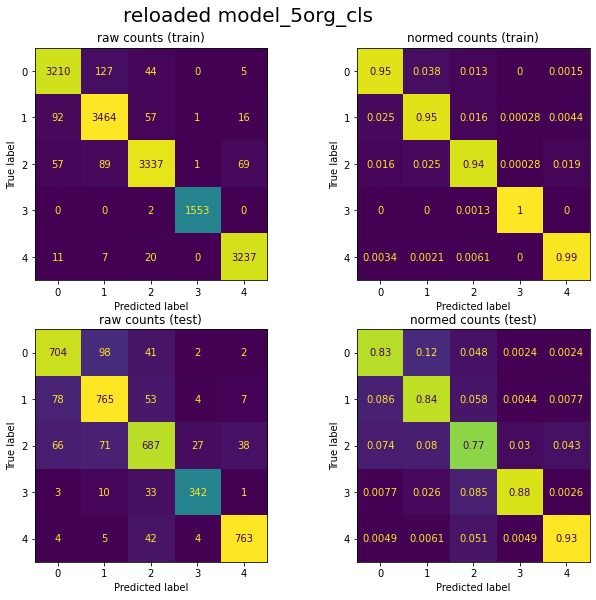

In [5]:
temp_train_df = pd.read_csv(f'data/5org_ups_cls_splits/cv0_train.tsv',sep='\t')
temp_test_df = pd.read_csv(f'data/5org_ups_cls_splits/cv0_test.tsv',sep='\t')

temp_seq_list = [
    (temp_train_df['upstream_region'].values,temp_train_df['id'],"train"),
    (temp_test_df['upstream_region'].values,temp_test_df['id'],"test")
]

tu.get_confusion_stats(
    model_5org_cls.to(DEVICE),
    'reloaded model_5org_cls',
    temp_seq_list,
    DEVICE,
    title=f"reloaded model_5org_cls",
)

looks good, now extract the relevant layers (all but the last layer)

In [6]:
def see_model_layers(model):
    extracted_layers = {k: v for k, v in model.state_dict().items()}
    extracted_layers_shapes = [(k,extracted_layers[k].shape) for k in extracted_layers]
    for x in extracted_layers_shapes:
        print(x)

In [7]:
see_model_layers(model_5org_cls)

('conv_net.0.weight', torch.Size([32, 1, 4, 10]))
('conv_net.0.bias', torch.Size([32]))
('conv_net.4.weight', torch.Size([32, 32, 1, 6]))
('conv_net.4.bias', torch.Size([32]))
('conv_net.8.weight', torch.Size([50, 4480]))
('conv_net.8.bias', torch.Size([50]))
('conv_net.10.weight', torch.Size([50, 50]))
('conv_net.10.bias', torch.Size([50]))
('conv_net.12.weight', torch.Size([5, 50]))
('conv_net.12.bias', torch.Size([5]))


Remove the weight and bias of the final layer, so we can change the prediction task head

In [8]:
# Exclude final layer of model.state_dict 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
model_5org_cls_weights = {k: v for k, v in model_5org_cls.state_dict().items() if k not in to_exclude}
model_5org_cls_weights.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

### now try prediction task with warm models

In [9]:
model_res = {}
pred_dfs = {}

___Running CV0___


E:177 | train loss:0.046 | val loss: 0.863:   4%|▎         | 178/5000 [00:13<06:10, 13.01it/s]

EarlyStopping counter: 125 out of 500


E:302 | train loss:0.012 | val loss: 1.046:   6%|▌         | 302/5000 [00:23<06:03, 12.93it/s]

EarlyStopping counter: 250 out of 500


E:427 | train loss:0.015 | val loss: 1.237:   9%|▊         | 428/5000 [00:32<05:46, 13.21it/s]

EarlyStopping counter: 375 out of 500


E:550 | train loss:0.007 | val loss: 1.320:  11%|█         | 550/5000 [00:42<05:41, 13.02it/s]


EarlyStopping counter: 500 out of 500
Early stopping


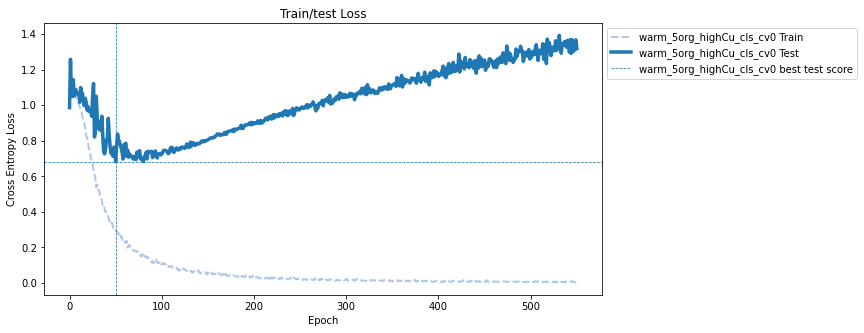

Running predictions for warm_5org_highCu_cls_cv0
___Running CV1___


E:191 | train loss:0.021 | val loss: 0.946:   4%|▍         | 192/5000 [00:14<06:10, 12.97it/s]

EarlyStopping counter: 125 out of 500


E:316 | train loss:0.007 | val loss: 1.139:   6%|▋         | 316/5000 [00:24<05:55, 13.18it/s]

EarlyStopping counter: 250 out of 500


E:441 | train loss:0.004 | val loss: 1.273:   9%|▉         | 442/5000 [00:33<05:44, 13.24it/s]

EarlyStopping counter: 375 out of 500


E:564 | train loss:0.001 | val loss: 1.380:  11%|█▏        | 564/5000 [00:43<05:39, 13.05it/s]


EarlyStopping counter: 500 out of 500
Early stopping


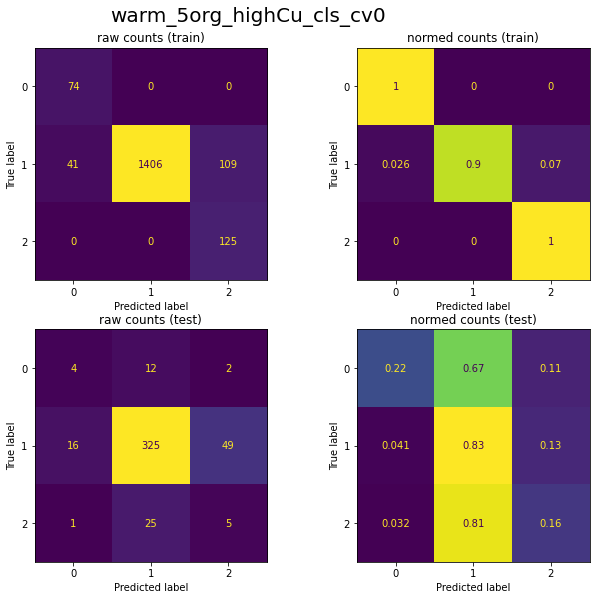

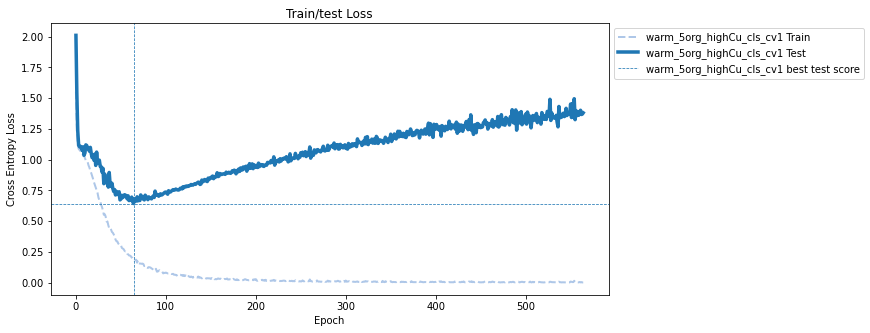

Running predictions for warm_5org_highCu_cls_cv1
___Running CV2___


E:178 | train loss:0.042 | val loss: 0.900:   4%|▎         | 179/5000 [00:13<06:11, 12.98it/s]

EarlyStopping counter: 125 out of 500


E:303 | train loss:0.010 | val loss: 1.093:   6%|▌         | 303/5000 [00:23<06:04, 12.89it/s]

EarlyStopping counter: 250 out of 500


E:428 | train loss:0.003 | val loss: 1.213:   9%|▊         | 429/5000 [00:33<05:54, 12.91it/s]

EarlyStopping counter: 375 out of 500


E:551 | train loss:0.002 | val loss: 1.352:  11%|█         | 551/5000 [00:42<05:45, 12.87it/s]


EarlyStopping counter: 500 out of 500
Early stopping


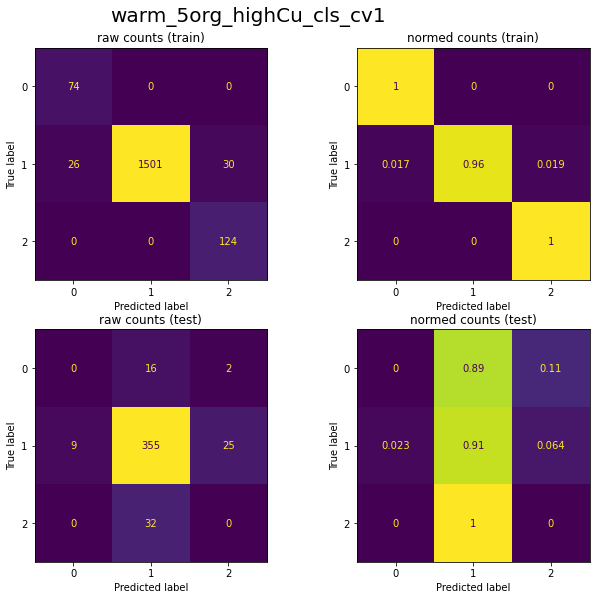

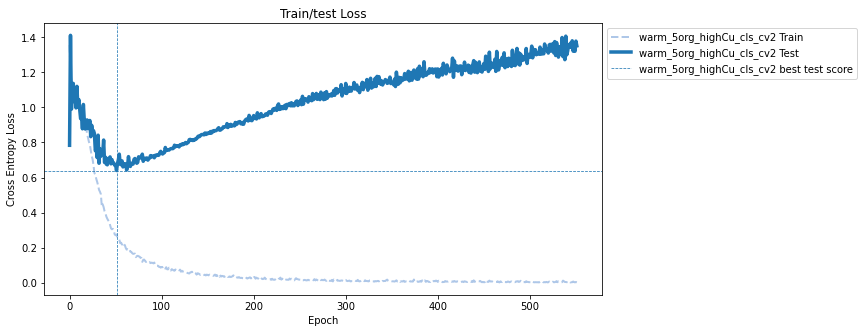

Running predictions for warm_5org_highCu_cls_cv2
___Running CV3___


E:186 | train loss:0.034 | val loss: 1.046:   4%|▎         | 187/5000 [00:14<06:06, 13.13it/s]

EarlyStopping counter: 125 out of 500


E:311 | train loss:0.013 | val loss: 1.280:   6%|▌         | 311/5000 [00:24<05:56, 13.14it/s]

EarlyStopping counter: 250 out of 500


E:436 | train loss:0.004 | val loss: 1.411:   9%|▊         | 437/5000 [00:33<05:48, 13.09it/s]

EarlyStopping counter: 375 out of 500


E:559 | train loss:0.006 | val loss: 1.581:  11%|█         | 559/5000 [00:43<05:41, 12.99it/s]


EarlyStopping counter: 500 out of 500
Early stopping


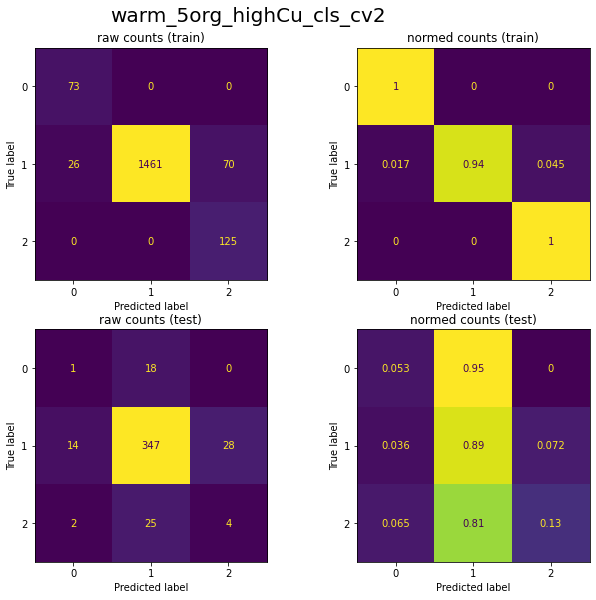

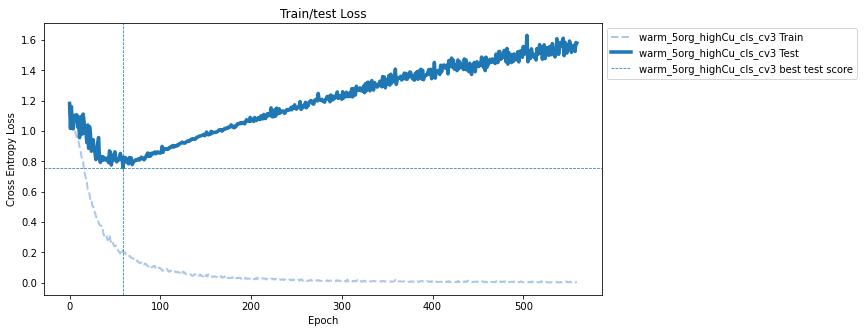

Running predictions for warm_5org_highCu_cls_cv3
___Running CV4___


E:188 | train loss:0.029 | val loss: 0.831:   4%|▍         | 189/5000 [00:14<06:07, 13.10it/s]

EarlyStopping counter: 125 out of 500


E:313 | train loss:0.010 | val loss: 1.032:   6%|▋         | 313/5000 [00:24<05:58, 13.07it/s]

EarlyStopping counter: 250 out of 500


E:438 | train loss:0.002 | val loss: 1.134:   9%|▉         | 439/5000 [00:33<05:50, 13.03it/s]

EarlyStopping counter: 375 out of 500


E:561 | train loss:0.002 | val loss: 1.181:  11%|█         | 561/5000 [00:43<05:41, 13.01it/s]


EarlyStopping counter: 500 out of 500
Early stopping


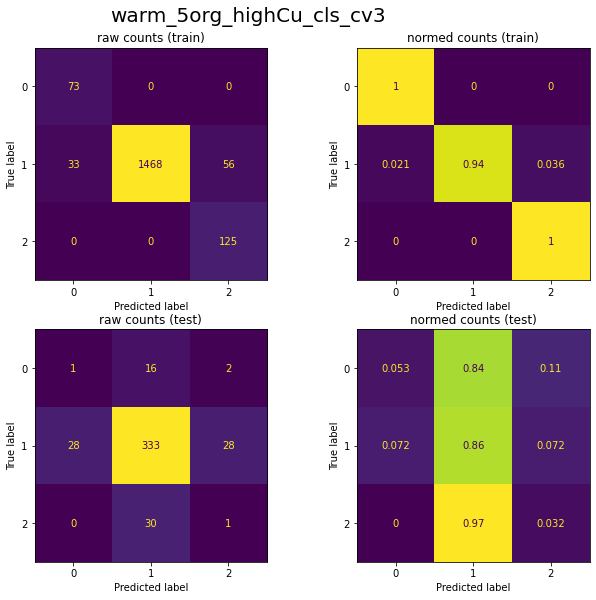

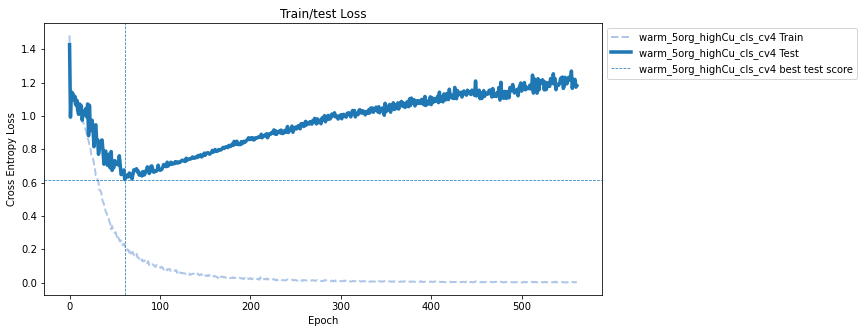

Running predictions for warm_5org_highCu_cls_cv4


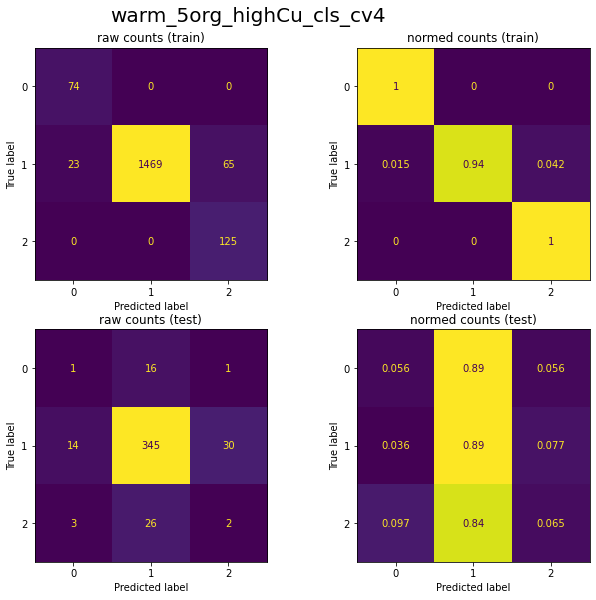

In [10]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_5org_highCu_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### train warm starts for shuffled seqs

___Running CV0___


E:198 | train loss:0.020 | val loss: 0.801:   4%|▍         | 198/5000 [00:15<06:14, 12.82it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.008 | val loss: 0.949:   6%|▋         | 324/5000 [00:25<06:01, 12.93it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.003 | val loss: 1.103:   9%|▉         | 448/5000 [00:35<05:54, 12.85it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.003 | val loss: 1.174:  11%|█▏        | 571/5000 [00:44<05:46, 12.80it/s]


EarlyStopping counter: 500 out of 500
Early stopping


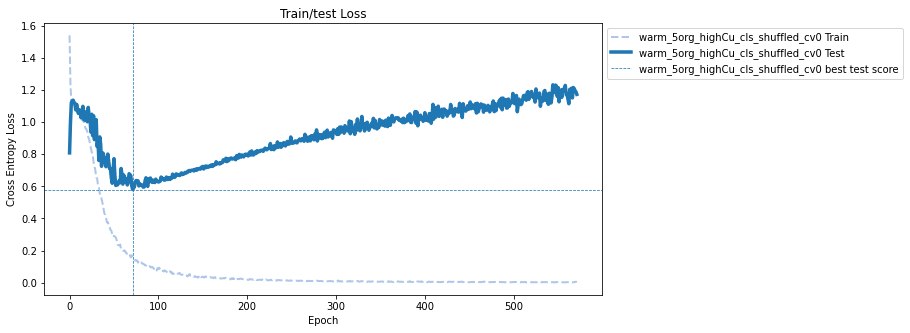

Running predictions for warm_5org_highCu_cls_shuffled_cv0
___Running CV1___


E:190 | train loss:0.023 | val loss: 0.955:   4%|▍         | 190/5000 [00:14<06:08, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:315 | train loss:0.008 | val loss: 1.151:   6%|▋         | 316/5000 [00:24<06:03, 12.88it/s]

EarlyStopping counter: 250 out of 500


E:440 | train loss:0.007 | val loss: 1.308:   9%|▉         | 440/5000 [00:34<05:48, 13.09it/s]

EarlyStopping counter: 375 out of 500


E:563 | train loss:0.002 | val loss: 1.435:  11%|█▏        | 563/5000 [00:43<05:42, 12.97it/s]


EarlyStopping counter: 500 out of 500
Early stopping


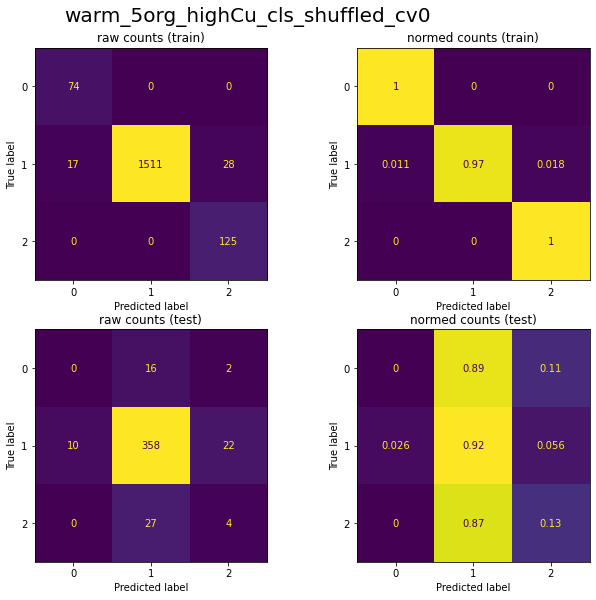

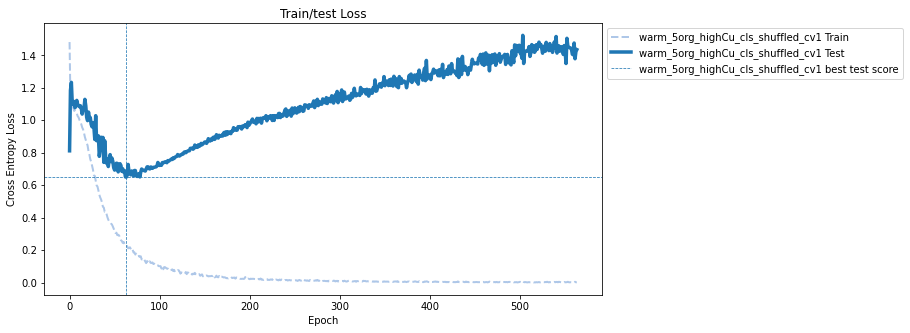

Running predictions for warm_5org_highCu_cls_shuffled_cv1
___Running CV2___


E:171 | train loss:0.029 | val loss: 0.889:   3%|▎         | 172/5000 [00:13<06:12, 12.97it/s]

EarlyStopping counter: 125 out of 500


E:296 | train loss:0.008 | val loss: 1.092:   6%|▌         | 296/5000 [00:22<05:58, 13.10it/s]

EarlyStopping counter: 250 out of 500


E:421 | train loss:0.004 | val loss: 1.201:   8%|▊         | 422/5000 [00:32<05:48, 13.14it/s]

EarlyStopping counter: 375 out of 500


E:544 | train loss:0.004 | val loss: 1.312:  11%|█         | 544/5000 [00:41<05:42, 13.01it/s]


EarlyStopping counter: 500 out of 500
Early stopping


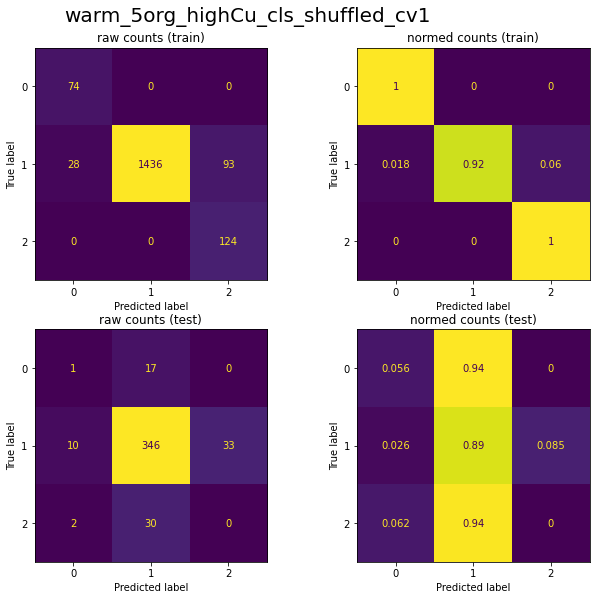

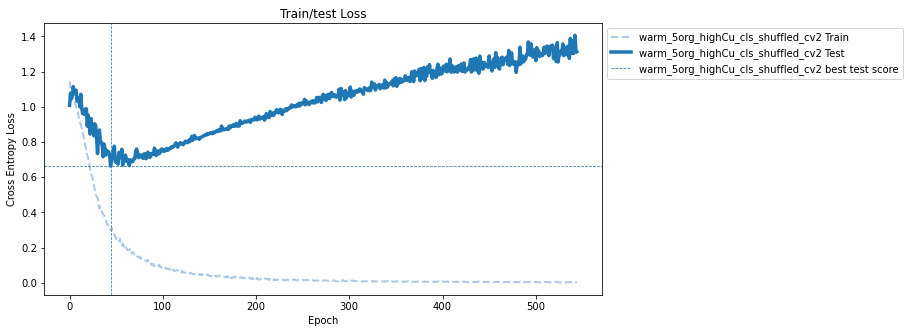

Running predictions for warm_5org_highCu_cls_shuffled_cv2
___Running CV3___


E:197 | train loss:0.021 | val loss: 0.749:   4%|▍         | 198/5000 [00:15<06:13, 12.86it/s]

EarlyStopping counter: 125 out of 500


E:322 | train loss:0.009 | val loss: 0.976:   6%|▋         | 322/5000 [00:25<06:02, 12.92it/s]

EarlyStopping counter: 250 out of 500


E:447 | train loss:0.002 | val loss: 1.126:   9%|▉         | 448/5000 [00:34<05:53, 12.88it/s]

EarlyStopping counter: 375 out of 500


E:570 | train loss:0.001 | val loss: 1.178:  11%|█▏        | 570/5000 [00:44<05:45, 12.82it/s]


EarlyStopping counter: 500 out of 500
Early stopping


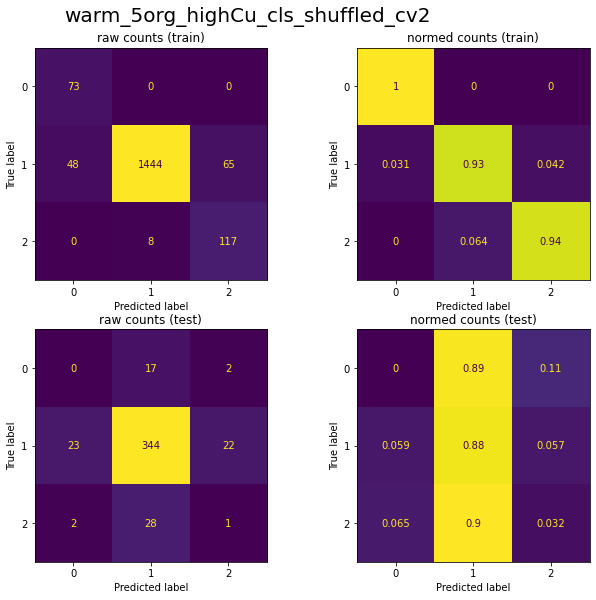

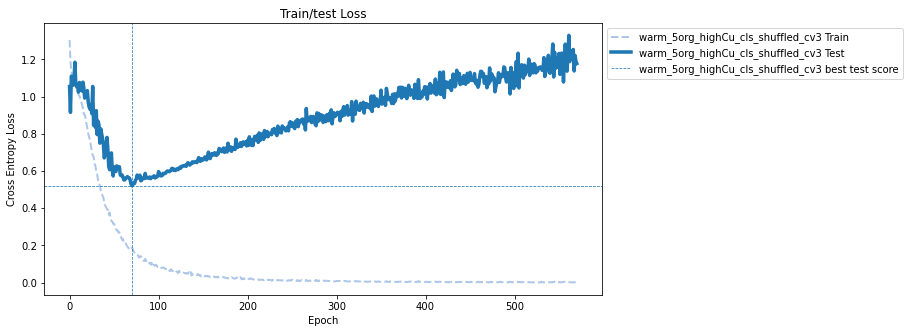

Running predictions for warm_5org_highCu_cls_shuffled_cv3
___Running CV4___


E:172 | train loss:0.038 | val loss: 0.880:   3%|▎         | 172/5000 [00:13<06:12, 12.98it/s]

EarlyStopping counter: 125 out of 500


E:297 | train loss:0.012 | val loss: 1.083:   6%|▌         | 298/5000 [00:22<05:58, 13.11it/s]

EarlyStopping counter: 250 out of 500


E:422 | train loss:0.008 | val loss: 1.204:   8%|▊         | 422/5000 [00:32<05:51, 13.02it/s]

EarlyStopping counter: 375 out of 500


E:545 | train loss:0.008 | val loss: 1.441:  11%|█         | 545/5000 [00:41<05:41, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


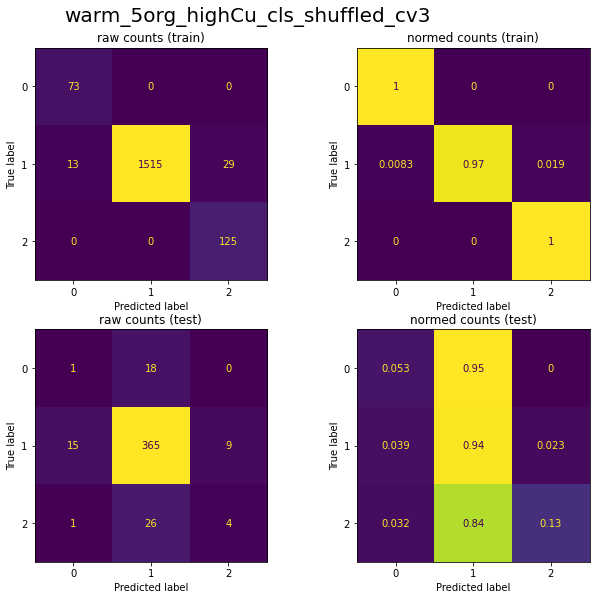

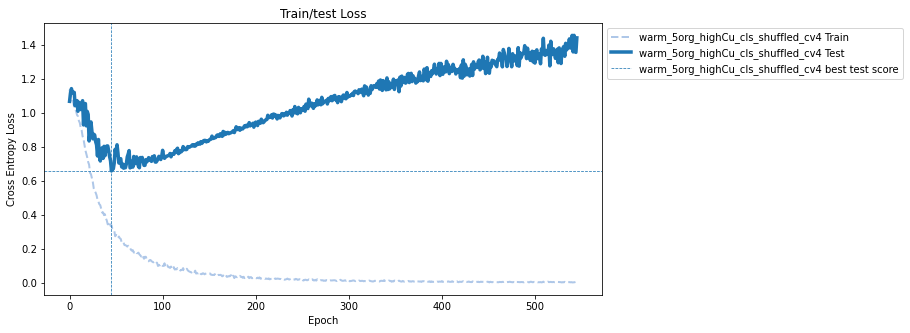

Running predictions for warm_5org_highCu_cls_shuffled_cv4


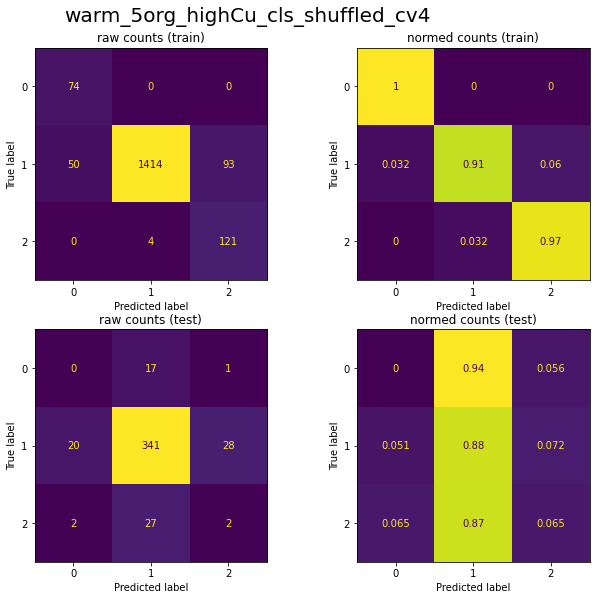

In [11]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_5org_highCu_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

In [12]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

model_name  split  mac_precision  mac_recall  \
0           warm_5org_highCu_cls_cv0  train       0.725889    0.967866   
1           warm_5org_highCu_cls_cv0   test       0.392517    0.405615   
0           warm_5org_highCu_cls_cv1  train       0.848398    0.988011   
1           warm_5org_highCu_cls_cv1   test       0.293631    0.304199   
0           warm_5org_highCu_cls_cv2  train       0.792800    0.979448   
1           warm_5org_highCu_cls_cv2   test       0.357856    0.357898   
0           warm_5org_highCu_cls_cv3  train       0.793096    0.980946   
1           warm_5org_highCu_cls_cv3   test       0.315123    0.313644   
0           warm_5org_highCu_cls_cv4  train       0.806927    0.981160   
1           warm_5org_highCu_cls_cv4   test       0.335878    0.335654   
0  warm_5org_highCu_cls_shuffled_cv0  train       0.876727    0.990360   
1  warm_5org_highCu_cls_shuffled_cv0   test       0.345208    0.348994   
0  warm_5org_highCu_cls_shuffled_cv1  train       0.765640    0.974095   
1  warm_5org_highCu_cls_shuffled_cv1   test       0.319110    0.315005   
0  warm_5org_highCu_cls_shuffled_cv2  train       0.746884    0.954475   
1  warm_5org_highCu_cls_shuffled_cv2   test       0.308106    0.305526   
0  warm_5org_highCu_cls_shuffled_cv3  train       0.886842    0.991008   
1  warm_5org_highCu_cls_shuffled_cv3   test       0.419645    0.373322   
0  warm_5org_highCu_cls_shuffled_cv4  train       0.719791    0.958719   
1  warm_5org_highCu_cls_shuffled_cv4   test       0.316743    0.313708   

     mac_f1  support model_type  seq_mode  fold        task  \
0  0.809602     1755        CNN   regular     0  highCu_cls   
1  0.394811      439        CNN   regular     0  highCu_cls   
0  0.908116     1755        CNN   regular     1  highCu_cls   
1  0.298822      439        CNN   regular     1  highCu_cls   
0  0.866093     1755        CNN   regular     2  highCu_cls   
1  0.357808      439        CNN   regular     2  highCu_cls   
0  0.867738     1755        CNN   regular     3  highCu_cls   
1  0.313704      439        CNN   regular     3  highCu_cls   
0  0.876689     1756        CNN   regular     4  highCu_cls   
1  0.335744      438        CNN   regular     4  highCu_cls   
0  0.927193     1755        CNN  shuffled     0  highCu_cls   
1  0.346926      439        CNN  shuffled     0  highCu_cls   
0  0.842585     1755        CNN  shuffled     1  highCu_cls   
1  0.316476      439        CNN  shuffled     1  highCu_cls   
0  0.824860     1755        CNN  shuffled     2  highCu_cls   
1  0.306678      439        CNN  shuffled     2  highCu_cls   
0  0.933541     1755        CNN  shuffled     3  highCu_cls   
1  0.384054      439        CNN  shuffled     3  highCu_cls   
0  0.803976     1756        CNN  shuffled     4  highCu_cls   
1  0.315218      438        CNN  shuffled     4  highCu_cls   

                    start  best_val_score  epoch_stop  total_time  
0  model_5org_cls_weights        0.683047          50   42.246938  
1  model_5org_cls_weights        0.683047          50   42.246938  
0  model_5org_cls_weights        0.642842          64   43.220965  
1  model_5org_cls_weights        0.642842          64   43.220965  
0  model_5org_cls_weights        0.640104          51   42.804388  
1  model_5org_cls_weights        0.640104          51   42.804388  
0  model_5org_cls_weights        0.757915          59   43.023819  
1  model_5org_cls_weights        0.757915          59   43.023819  
0  model_5org_cls_weights        0.618233          61   43.119042  
1  model_5org_cls_weights        0.618233          61   43.119042  
0  model_5org_cls_weights        0.579799          71   44.618622  
1  model_5org_cls_weights        0.579799          71   44.618622  
0  model_5org_cls_weights        0.650222          63   43.418493  
1  model_5org_cls_weights        0.650222          63   43.418493  
0  model_5org_cls_weights        0.662800          44   41.822807  
1  model_5org_cls_weights        0.662800          44   41.

In [13]:
def plot_metric(df,metric):
    sns.barplot(data=df,y='model_name',x=metric,hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel(f"{metric} score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

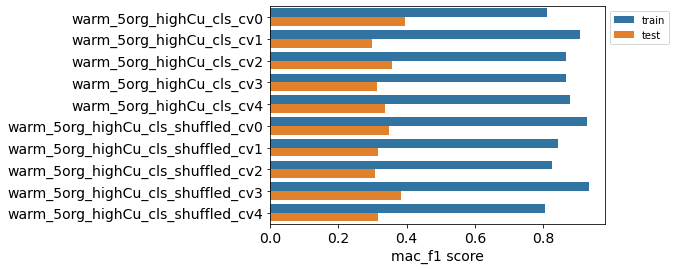

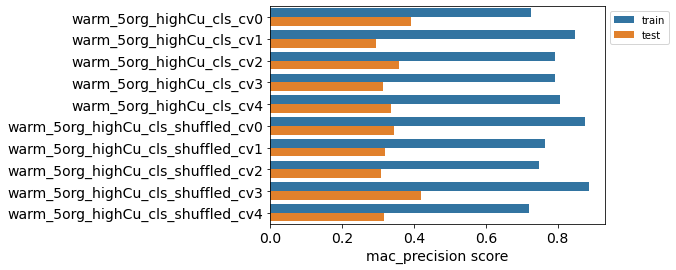

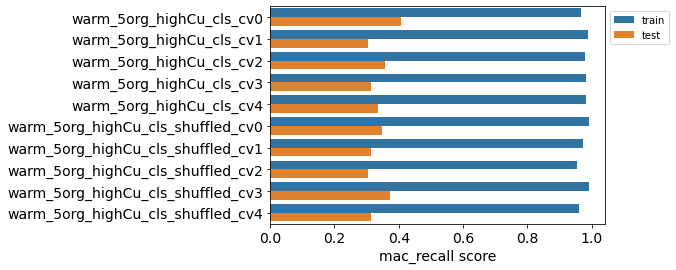

In [14]:
plot_metric(all_preds,'mac_f1')
plot_metric(all_preds,'mac_precision')
plot_metric(all_preds,'mac_recall')

In [15]:
df_train = all_preds[all_preds['split']=='train']
df_test = all_preds[all_preds['split']=='test']

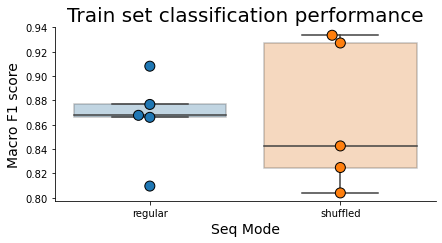

In [16]:
g = sns.catplot(
    data=df_train, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set classification performance",fontsize=20)
plt.show()

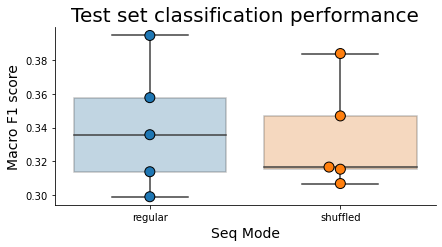

In [17]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set classification performance",fontsize=20)
plt.show()

In [18]:
from scipy.stats import ttest_ind

In [19]:
regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
print("T-test:",ttest_ind(regular_scores, shuffled_scores))
print()
print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))

T-test: Ttest_indResult(statistic=0.28487748286830894, pvalue=0.7829736410373656)

Mean Mac F1 for regular seqs: 0.34017770402859393
Mean Mac F1 for shuffled seqs: 0.33386999893851743


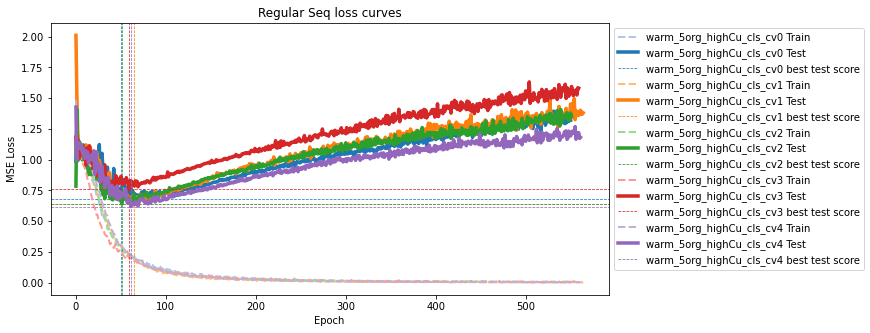

<Figure size 432x288 with 0 Axes>

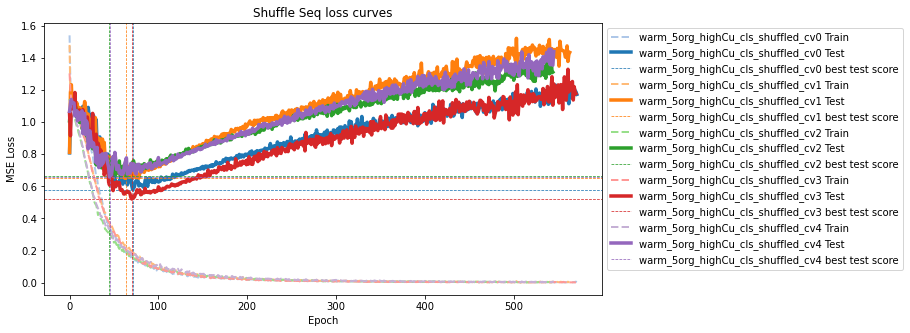

<Figure size 432x288 with 0 Axes>

In [20]:
tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_cls/regular_seq_W:5orgCLS_loss_plot.png'
)

tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_cls/shuffle_seq_W:5orgCLS_loss_plot.png'
)

CHECK RESULTS?^^?

In [ ]:
# hm, wait and try other warm starts too?
#all_preds.to_csv('out_warmStart_highCu_cls/all_pred_res.tsv',sep='\t',index=False)


## Try warm start on 5org_cls for *Regression* task

In [21]:
model_res_regr = {}
pred_dfs_regr = {}

___Running CV0___


E:176 | train loss:1.415 | val loss: 4.585:   4%|▎         | 176/5000 [00:13<06:11, 12.99it/s]

EarlyStopping counter: 125 out of 500


E:301 | train loss:0.677 | val loss: 4.732:   6%|▌         | 302/5000 [00:23<06:02, 12.95it/s]

EarlyStopping counter: 250 out of 500


E:426 | train loss:0.468 | val loss: 4.755:   9%|▊         | 426/5000 [00:33<05:49, 13.08it/s]

EarlyStopping counter: 375 out of 500


E:549 | train loss:0.352 | val loss: 4.712:  11%|█         | 549/5000 [00:42<05:44, 12.91it/s]


EarlyStopping counter: 500 out of 500
Early stopping


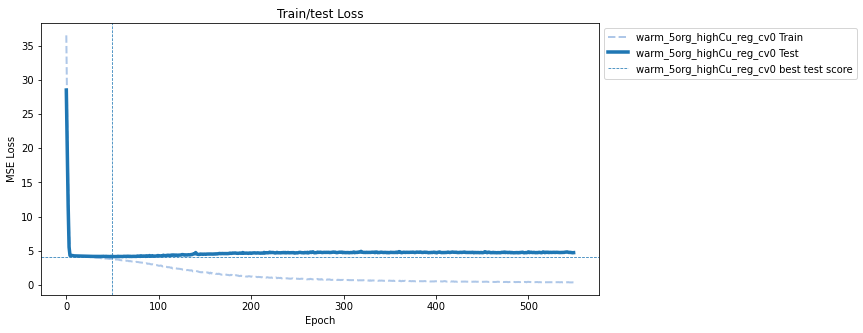

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


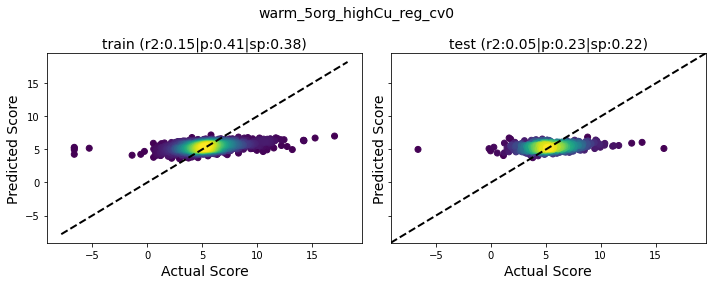

___Running CV1___


E:218 | train loss:1.272 | val loss: 4.686:   4%|▍         | 219/5000 [00:16<06:05, 13.09it/s]

EarlyStopping counter: 125 out of 500


E:343 | train loss:0.647 | val loss: 4.665:   7%|▋         | 343/5000 [00:26<05:55, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:468 | train loss:0.485 | val loss: 4.669:   9%|▉         | 469/5000 [00:35<05:46, 13.09it/s]

EarlyStopping counter: 375 out of 500


E:591 | train loss:0.344 | val loss: 4.629:  12%|█▏        | 591/5000 [00:45<05:38, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


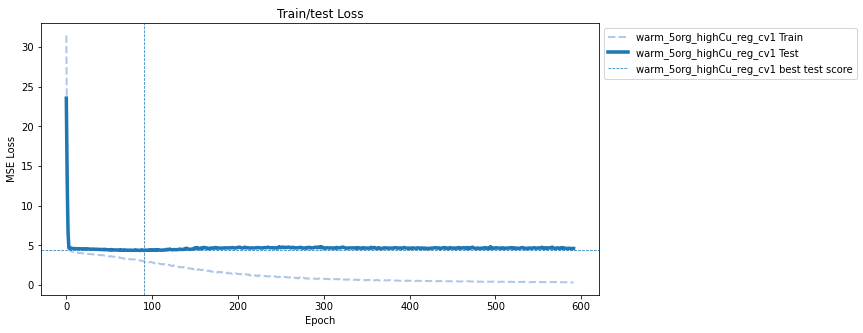

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


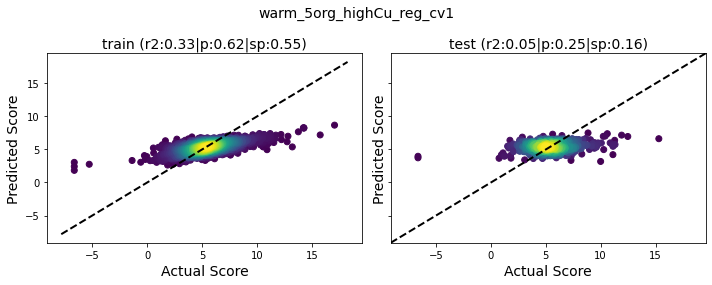

___Running CV2___


E:171 | train loss:1.569 | val loss: 4.018:   3%|▎         | 172/5000 [00:13<06:14, 12.87it/s]

EarlyStopping counter: 125 out of 500


E:296 | train loss:0.841 | val loss: 4.158:   6%|▌         | 296/5000 [00:23<06:06, 12.83it/s]

EarlyStopping counter: 250 out of 500


E:421 | train loss:0.594 | val loss: 4.072:   8%|▊         | 422/5000 [00:33<05:55, 12.87it/s]

EarlyStopping counter: 375 out of 500


E:544 | train loss:0.428 | val loss: 4.013:  11%|█         | 544/5000 [00:42<05:49, 12.75it/s]


EarlyStopping counter: 500 out of 500
Early stopping


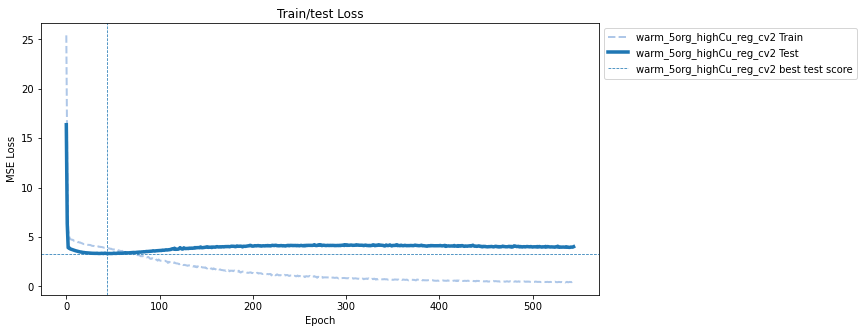

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


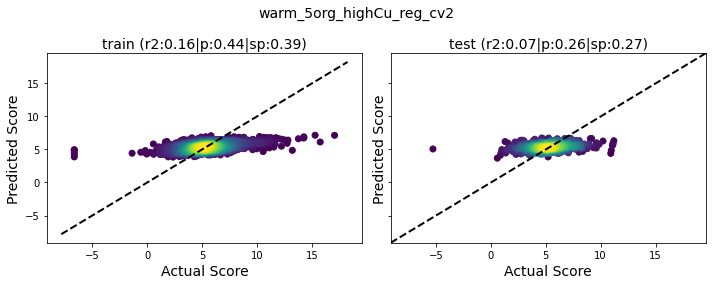

___Running CV3___


E:148 | train loss:1.573 | val loss: 5.099:   3%|▎         | 148/5000 [00:11<06:16, 12.88it/s]

EarlyStopping counter: 125 out of 500


E:273 | train loss:0.723 | val loss: 5.326:   5%|▌         | 274/5000 [00:21<06:05, 12.94it/s]

EarlyStopping counter: 250 out of 500


E:398 | train loss:0.477 | val loss: 5.069:   8%|▊         | 398/5000 [00:31<05:59, 12.81it/s]

EarlyStopping counter: 375 out of 500


E:521 | train loss:0.364 | val loss: 4.901:  10%|█         | 521/5000 [00:40<05:49, 12.83it/s]


EarlyStopping counter: 500 out of 500
Early stopping


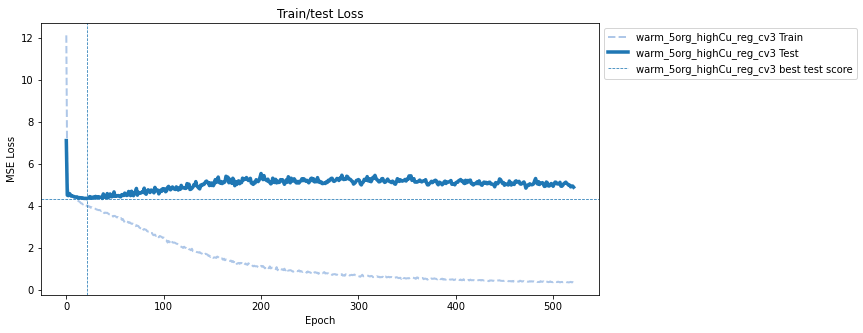

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


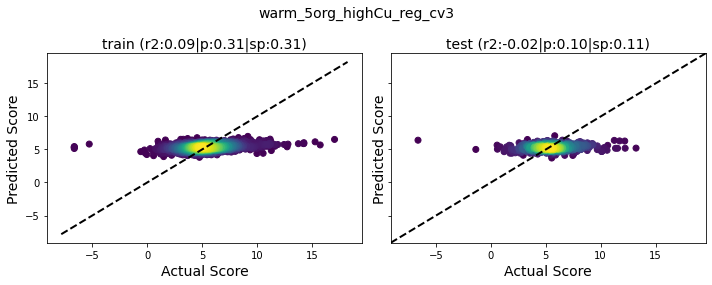

___Running CV4___


E:166 | train loss:1.745 | val loss: 5.328:   3%|▎         | 166/5000 [00:12<06:11, 13.01it/s]

EarlyStopping counter: 125 out of 500


E:291 | train loss:0.865 | val loss: 5.291:   6%|▌         | 292/5000 [00:22<06:01, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:416 | train loss:0.586 | val loss: 5.213:   8%|▊         | 416/5000 [00:32<05:51, 13.03it/s]

EarlyStopping counter: 375 out of 500


E:539 | train loss:0.413 | val loss: 5.131:  11%|█         | 539/5000 [00:41<05:44, 12.94it/s]


EarlyStopping counter: 500 out of 500
Early stopping


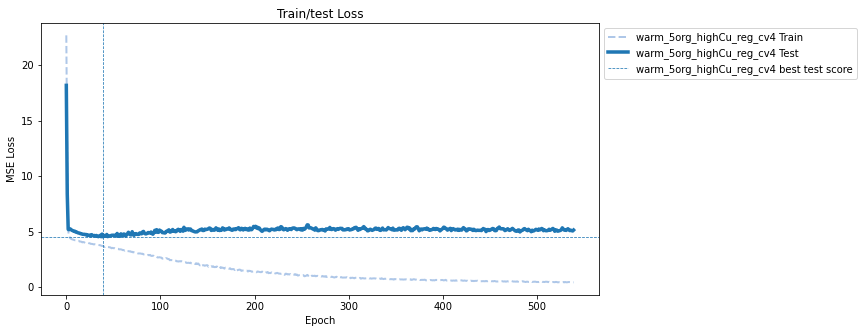

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


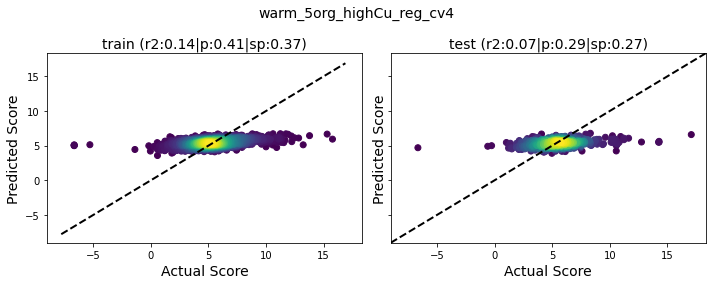

In [22]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'upstream_region'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_5org_highCu_reg_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

### Regression from 5org_cls shuffled

___Running CV0___


E:148 | train loss:2.080 | val loss: 5.562:   3%|▎         | 148/5000 [00:11<06:11, 13.08it/s]

EarlyStopping counter: 125 out of 500


E:273 | train loss:0.959 | val loss: 5.753:   5%|▌         | 274/5000 [00:21<06:01, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:398 | train loss:0.639 | val loss: 5.656:   8%|▊         | 398/5000 [00:30<05:52, 13.05it/s]

EarlyStopping counter: 375 out of 500


E:521 | train loss:0.469 | val loss: 5.539:  10%|█         | 521/5000 [00:40<05:44, 13.00it/s]


EarlyStopping counter: 500 out of 500
Early stopping


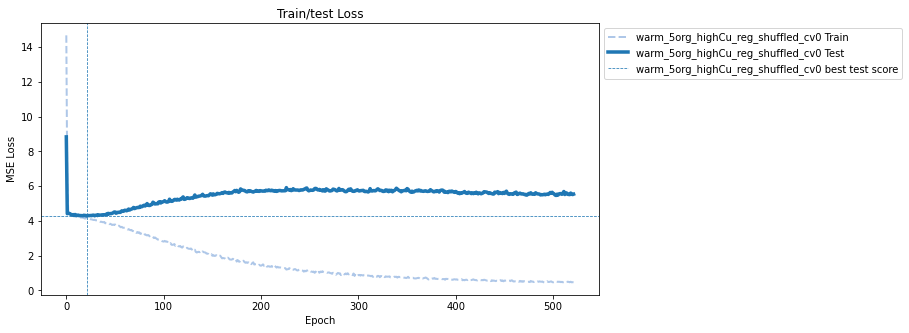

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_shuffled_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_shuffled_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


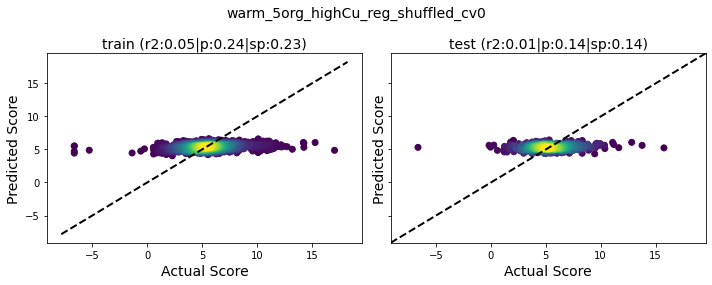

___Running CV1___


E:131 | train loss:2.537 | val loss: 5.715:   3%|▎         | 132/5000 [00:10<06:20, 12.80it/s]

EarlyStopping counter: 125 out of 500


E:256 | train loss:1.049 | val loss: 5.739:   5%|▌         | 256/5000 [00:20<06:08, 12.89it/s]

EarlyStopping counter: 250 out of 500


E:381 | train loss:0.666 | val loss: 5.617:   8%|▊         | 382/5000 [00:29<05:57, 12.92it/s]

EarlyStopping counter: 375 out of 500


E:504 | train loss:0.493 | val loss: 5.407:  10%|█         | 504/5000 [00:39<05:51, 12.79it/s]


EarlyStopping counter: 500 out of 500
Early stopping


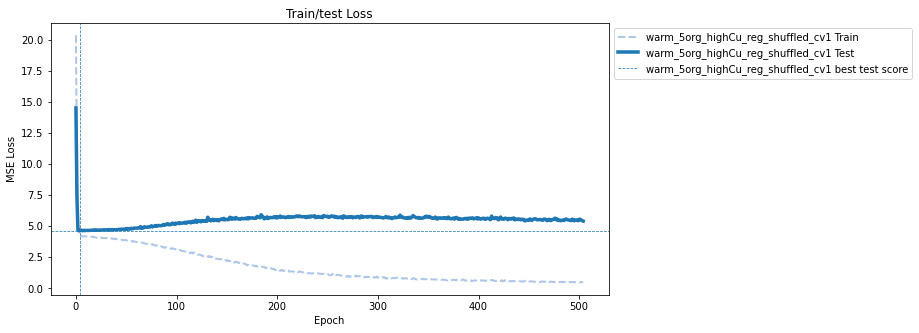

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_shuffled_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_shuffled_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


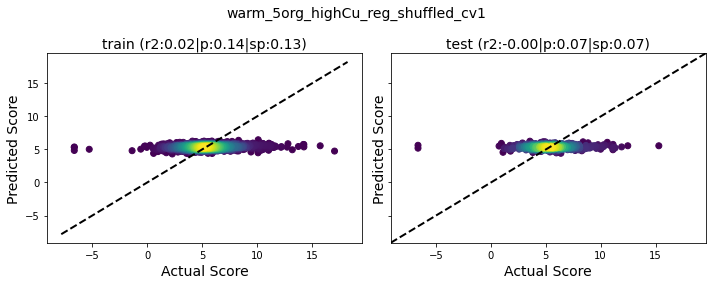

___Running CV2___


E:160 | train loss:1.808 | val loss: 4.531:   3%|▎         | 161/5000 [00:12<06:14, 12.94it/s]

EarlyStopping counter: 125 out of 500


E:285 | train loss:0.946 | val loss: 4.690:   6%|▌         | 285/5000 [00:22<06:04, 12.93it/s]

EarlyStopping counter: 250 out of 500


E:410 | train loss:0.564 | val loss: 4.546:   8%|▊         | 411/5000 [00:32<05:56, 12.88it/s]

EarlyStopping counter: 375 out of 500


E:533 | train loss:0.425 | val loss: 4.331:  11%|█         | 533/5000 [00:41<05:49, 12.79it/s]


EarlyStopping counter: 500 out of 500
Early stopping


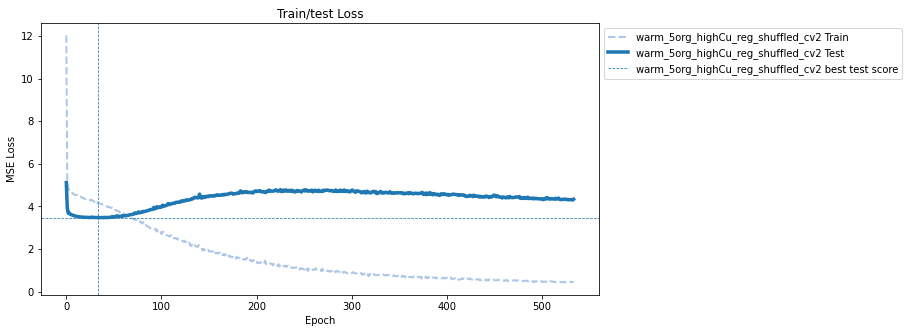

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_shuffled_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_shuffled_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


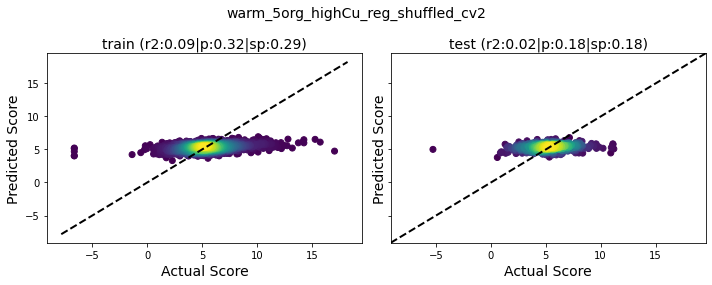

___Running CV3___


E:160 | train loss:2.478 | val loss: 4.891:   3%|▎         | 160/5000 [00:12<06:13, 12.96it/s]

EarlyStopping counter: 125 out of 500


E:285 | train loss:1.006 | val loss: 5.314:   6%|▌         | 286/5000 [00:22<06:05, 12.89it/s]

EarlyStopping counter: 250 out of 500


E:410 | train loss:0.587 | val loss: 5.224:   8%|▊         | 410/5000 [00:31<05:56, 12.88it/s]

EarlyStopping counter: 375 out of 500


E:533 | train loss:0.445 | val loss: 4.987:  11%|█         | 533/5000 [00:41<05:47, 12.86it/s]


EarlyStopping counter: 500 out of 500
Early stopping


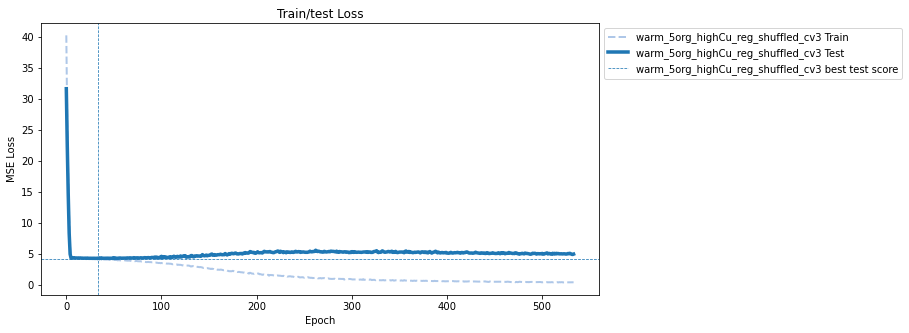

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_shuffled_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_shuffled_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


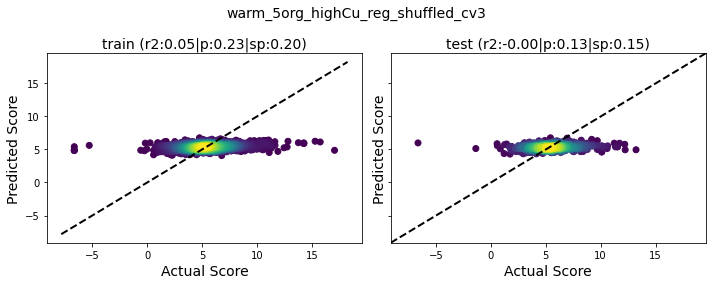

___Running CV4___


E:196 | train loss:1.849 | val loss: 5.248:   4%|▍         | 196/5000 [00:15<06:09, 13.00it/s]

EarlyStopping counter: 125 out of 500


E:321 | train loss:0.831 | val loss: 5.777:   6%|▋         | 322/5000 [00:25<06:00, 12.97it/s]

EarlyStopping counter: 250 out of 500


E:446 | train loss:0.575 | val loss: 5.848:   9%|▉         | 446/5000 [00:34<05:48, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:569 | train loss:0.423 | val loss: 5.743:  11%|█▏        | 569/5000 [00:44<05:42, 12.92it/s]


EarlyStopping counter: 500 out of 500
Early stopping


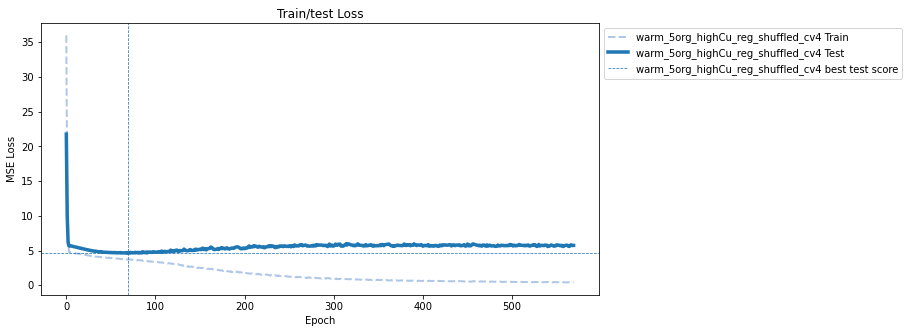

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5org_highCu_reg_shuffled_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5org_highCu_reg_shuffled_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


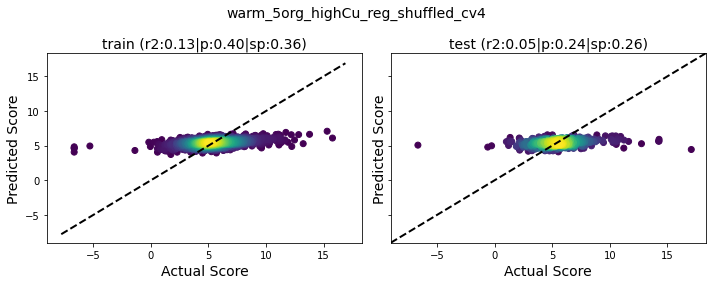

In [23]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'shuffled_seq'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_5org_highCu_reg_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

### Compare overall predictions of warm start for regression

In [24]:
all_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr])
all_preds_regr

model_name  split        r2   pearson  spearman  \
0           warm_5org_highCu_reg_cv0  train  0.145859  0.409594  0.379183   
1           warm_5org_highCu_reg_cv0   test  0.052195  0.229713  0.220709   
0           warm_5org_highCu_reg_cv1  train  0.330154  0.621326  0.554501   
1           warm_5org_highCu_reg_cv1   test  0.051342  0.252938  0.160876   
0           warm_5org_highCu_reg_cv2  train  0.162496  0.440514  0.387737   
1           warm_5org_highCu_reg_cv2   test  0.067611  0.263854  0.269337   
0           warm_5org_highCu_reg_cv3  train  0.087045  0.310455  0.306270   
1           warm_5org_highCu_reg_cv3   test -0.020327  0.100886  0.113511   
0           warm_5org_highCu_reg_cv4  train  0.138703  0.406890  0.373681   
1           warm_5org_highCu_reg_cv4   test  0.071179  0.287709  0.272393   
0  warm_5org_highCu_reg_shuffled_cv0  train  0.050683  0.236340  0.228432   
1  warm_5org_highCu_reg_shuffled_cv0   test  0.014976  0.143158  0.138367   
0  warm_5org_highCu_reg_shuffled_cv1  train  0.015880  0.139027  0.125963   
1  warm_5org_highCu_reg_shuffled_cv1   test -0.004050  0.068310  0.072173   
0  warm_5org_highCu_reg_shuffled_cv2  train  0.087772  0.324808  0.289976   
1  warm_5org_highCu_reg_shuffled_cv2   test  0.024957  0.178186  0.182511   
0  warm_5org_highCu_reg_shuffled_cv3  train  0.048706  0.225544  0.203991   
1  warm_5org_highCu_reg_shuffled_cv3   test -0.000693  0.127854  0.149048   
0  warm_5org_highCu_reg_shuffled_cv4  train  0.130672  0.397702  0.360354   
1  warm_5org_highCu_reg_shuffled_cv4   test  0.050465  0.238638  0.259934   

  model_type  seq_mode  fold                task                   start  \
0        CNN   regular     0  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     0  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     1  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     1  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     2  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     2  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     3  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     3  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     4  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     4  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     0  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     0  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     1  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     1  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     2  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     2  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     3  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     3  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     4  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     4  highCu_logTPM_regr  model_5org_cls_weights   

   best_val_score  epoch_stop  total_time  
0        4.120413          49   42.535132  
1        4.120413          49   42.535132  
0        4.373304          91   45.369373  
1        4.373304          91   45.369373  
0        3.318235          44   42.656218  
1        3.318235          44   42.656218  
0        4.355594          21   40.611444  
1        4.355594          21   40.611444  
0        4.523913          39   41.671491  
1        4.523913          39   41.671491  
0        4.282216          21   40.070257  
1        4.282216          21   40.070257  
0        4.628660           4   39.423538  
1        4.628660           4   39.423538  
0        3.470035          33   41.678150  
1        3.470035          33   41.678150  
0        4.271779          33   41.465554  
1        4.271779  

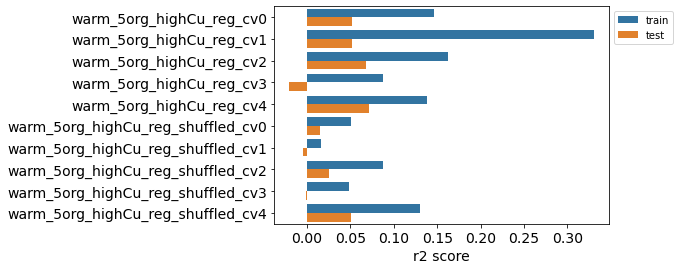

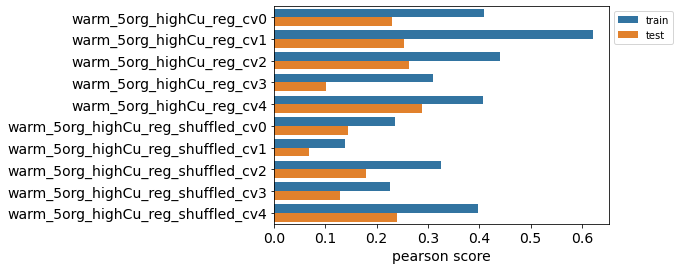

In [25]:
plot_metric(all_preds_regr,'r2')
plot_metric(all_preds_regr,'pearson')

In [26]:
df_train = all_preds_regr[all_preds_regr['split']=='train']
df_test = all_preds_regr[all_preds_regr['split']=='test']

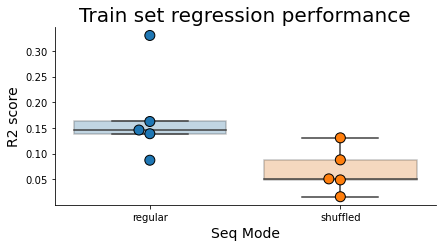

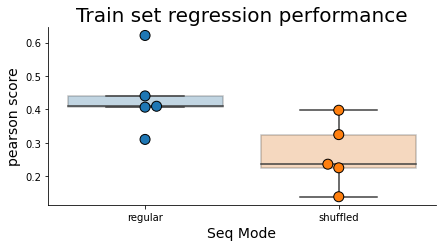

In [27]:
# TRAIN
g = sns.catplot(
    data=df_train, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_train, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

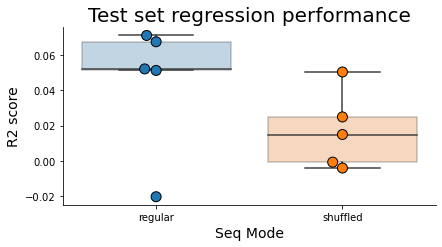

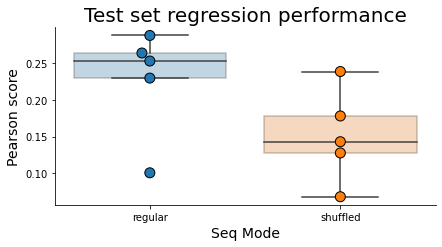

In [28]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_test, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

In [29]:
regular_r2scores = df_test[df_test['seq_mode']=='regular']['r2'].values
shuffled_r2scores = df_test[df_test['seq_mode']=='shuffled']['r2'].values
print("R2")
print(ttest_ind(regular_r2scores, shuffled_r2scores))

regular_pearsonscores = df_test[df_test['seq_mode']=='regular']['pearson'].values
shuffled_pearsonscores = df_test[df_test['seq_mode']=='shuffled']['pearson'].values
print("Pearson")
print(ttest_ind(regular_pearsonscores, shuffled_pearsonscores))

R2
Ttest_indResult(statistic=1.408373395764549, pvalue=0.19667644166994128)
Pearson
Ttest_indResult(statistic=1.7507150462252206, pvalue=0.11810423215051727)


In [30]:
print("Mean R2 for regular seqs:",np.mean(regular_r2scores))
print("Mean R2 for shuffled seqs:",np.mean(shuffled_r2scores))
print()
print("Mean Pearson for regular seqs:",np.mean(regular_pearsonscores))
print("Mean Pearson for shuffled seqs:",np.mean(shuffled_pearsonscores))

Mean R2 for regular seqs: 0.04440021154533473
Mean R2 for shuffled seqs: 0.01713120018342227

Mean Pearson for regular seqs: 0.2270198959527426
Mean Pearson for shuffled seqs: 0.15122920121936537


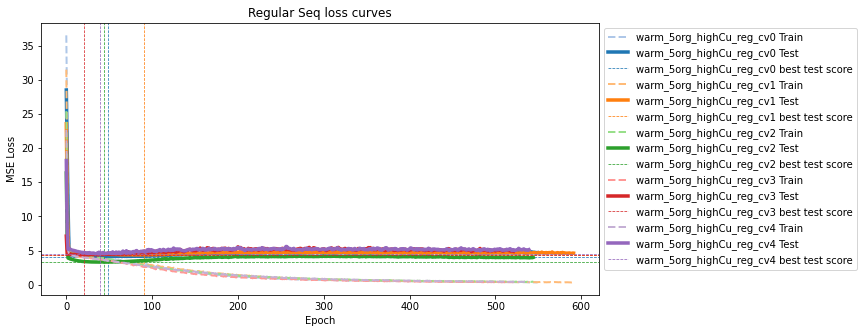

<Figure size 432x288 with 0 Axes>

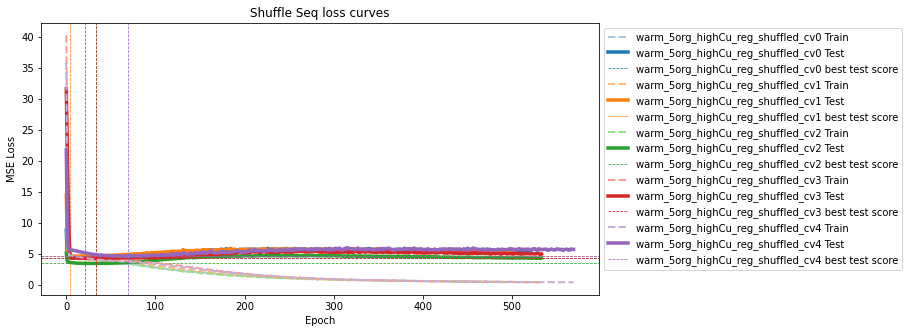

<Figure size 432x288 with 0 Axes>

In [31]:
tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_regr/regular_seq_W:5orgCLS_loss_plot.png'
)

tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_regr/shuffle_seq_W:5orgCLS_loss_plot.png'
)

In [ ]:
## CHECK RESULTS ^^

# Warm start with 5G CDS vs UPS classification model

### load 5G UPS/CDS classification model and confirm predictions on it's own data look correct


In [32]:
m_args_5g_ups_cds_cls = (seq_len,2)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

saved_5g_ups_cds_cls_filename = 'saved_models/5g_ups_cds_cls_cv0_model_state_dict.pt'
model_5g_ups_cds_cls = m.DNA_2CNN_2FC(*m_args_5g_ups_cds_cls,**m_kwargs)
model_5g_ups_cds_cls.load_state_dict(torch.load(saved_5g_ups_cds_cls_filename))
model_5g_ups_cds_cls


DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=2, bias=True)
  )
)

Running predictions for reloaded model_5g_ups_cds_cls


model_name  split  mac_precision  mac_recall    mac_f1  \
0  reloaded model_5g_ups_cds_cls  train        0.96355    0.961404  0.962470   
1  reloaded model_5g_ups_cds_cls   test        0.92006    0.913842  0.916887   

   support  
0    13088  
1     3272

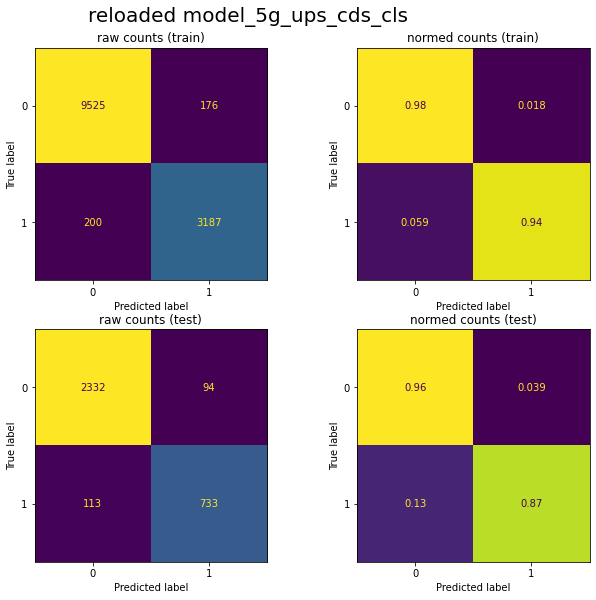

In [33]:
temp_train_df = pd.read_csv(f'data/5g_ups_cds_cls_splits/cv0_train.tsv',sep='\t')
temp_test_df = pd.read_csv(f'data/5g_ups_cds_cls_splits/cv0_test.tsv',sep='\t')

temp_seq_list = [
    (temp_train_df['seq'].values,temp_train_df['seq_type_id'],"train"),
    (temp_test_df['seq'].values,temp_test_df['seq_type_id'],"test")
]

tu.get_confusion_stats(
    model_5g_ups_cds_cls.to(DEVICE),
    'reloaded model_5g_ups_cds_cls',
    temp_seq_list,
    DEVICE,
    title=f"reloaded model_5g_ups_cds_cls",
)

looks good, now extract the relevant layers (all but the last layer)

In [34]:
see_model_layers(model_5g_ups_cds_cls)

('conv_net.0.weight', torch.Size([32, 1, 4, 10]))
('conv_net.0.bias', torch.Size([32]))
('conv_net.4.weight', torch.Size([32, 32, 1, 6]))
('conv_net.4.bias', torch.Size([32]))
('conv_net.8.weight', torch.Size([50, 4480]))
('conv_net.8.bias', torch.Size([50]))
('conv_net.10.weight', torch.Size([50, 50]))
('conv_net.10.bias', torch.Size([50]))
('conv_net.12.weight', torch.Size([2, 50]))
('conv_net.12.bias', torch.Size([2]))


Remove the weight and bias of the final layer, so we can change the prediction task head

In [35]:
# Exclude final layer of model.state_dict 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
model_5g_ups_cds_cls_weights = {k: v for k, v in model_5g_ups_cds_cls.state_dict().items() if k not in to_exclude}
model_5g_ups_cds_cls_weights.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

### cu classification task with 5g cds warm model

___Running CV0___


E:206 | train loss:0.037 | val loss: 0.869:   4%|▍         | 207/5000 [00:16<06:08, 13.02it/s]

EarlyStopping counter: 125 out of 500


E:331 | train loss:0.011 | val loss: 0.954:   7%|▋         | 331/5000 [00:25<05:59, 12.99it/s]

EarlyStopping counter: 250 out of 500


E:456 | train loss:0.013 | val loss: 1.027:   9%|▉         | 457/5000 [00:35<05:49, 13.01it/s]

EarlyStopping counter: 375 out of 500


E:579 | train loss:0.005 | val loss: 1.115:  12%|█▏        | 579/5000 [00:44<05:42, 12.91it/s]


EarlyStopping counter: 500 out of 500
Early stopping


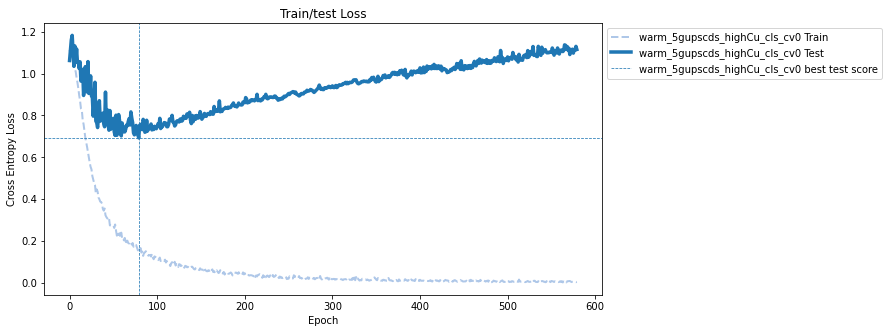

Running predictions for warm_5gupscds_highCu_cls_cv0
___Running CV1___


E:171 | train loss:0.022 | val loss: 0.968:   3%|▎         | 172/5000 [00:13<06:10, 13.04it/s]

EarlyStopping counter: 125 out of 500


E:296 | train loss:0.007 | val loss: 1.168:   6%|▌         | 296/5000 [00:22<06:01, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:421 | train loss:0.002 | val loss: 1.290:   8%|▊         | 422/5000 [00:32<05:48, 13.15it/s]

EarlyStopping counter: 375 out of 500


E:544 | train loss:0.006 | val loss: 1.436:  11%|█         | 544/5000 [00:41<05:42, 13.00it/s]


EarlyStopping counter: 500 out of 500
Early stopping


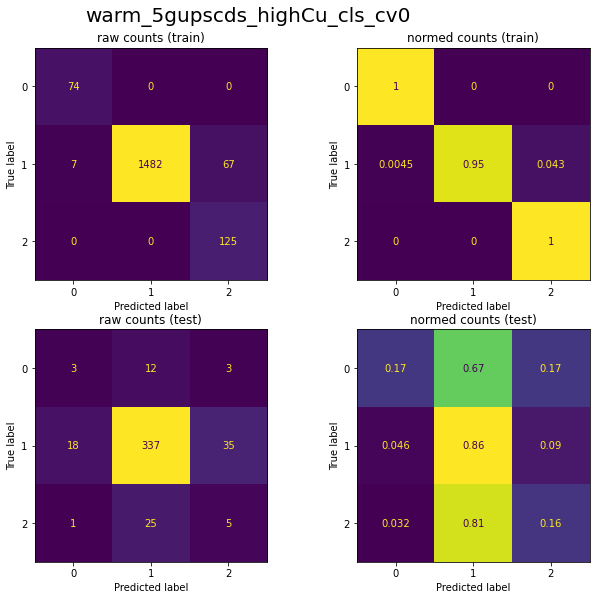

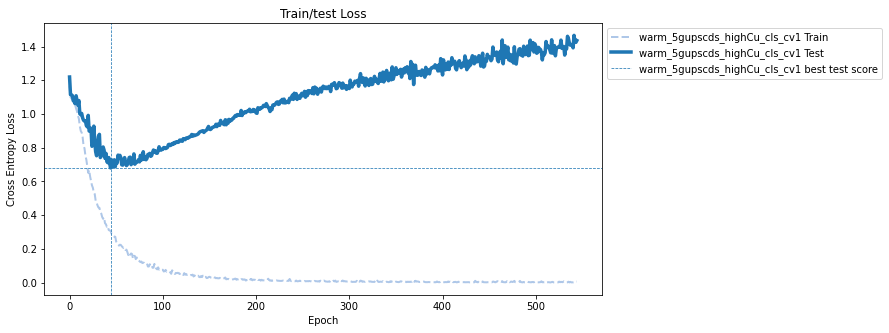

Running predictions for warm_5gupscds_highCu_cls_cv1
___Running CV2___


E:175 | train loss:0.055 | val loss: 0.898:   4%|▎         | 176/5000 [00:13<06:06, 13.17it/s]

EarlyStopping counter: 125 out of 500


E:300 | train loss:0.012 | val loss: 1.103:   6%|▌         | 300/5000 [00:22<05:56, 13.18it/s]

EarlyStopping counter: 250 out of 500


E:425 | train loss:0.013 | val loss: 1.214:   9%|▊         | 426/5000 [00:32<05:47, 13.15it/s]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.009 | val loss: 1.380:  11%|█         | 548/5000 [00:41<05:38, 13.14it/s]


EarlyStopping counter: 500 out of 500
Early stopping


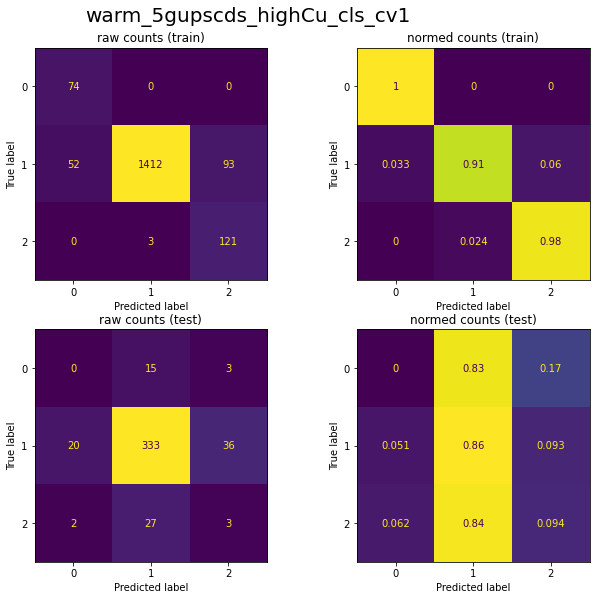

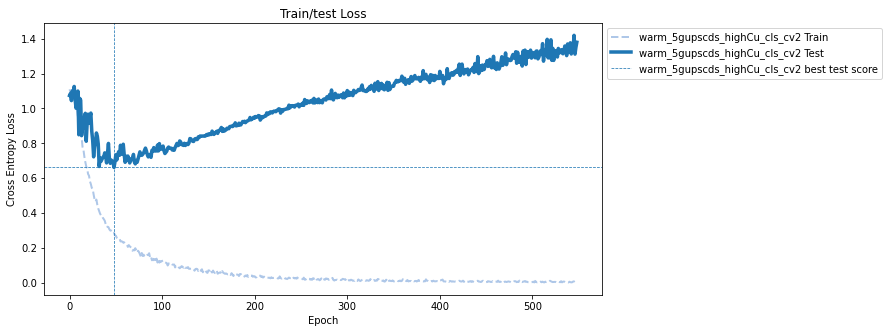

Running predictions for warm_5gupscds_highCu_cls_cv2
___Running CV3___


E:191 | train loss:0.027 | val loss: 0.855:   4%|▍         | 191/5000 [00:14<06:04, 13.21it/s]

EarlyStopping counter: 125 out of 500


E:316 | train loss:0.008 | val loss: 1.044:   6%|▋         | 317/5000 [00:24<05:54, 13.19it/s]

EarlyStopping counter: 250 out of 500


E:441 | train loss:0.006 | val loss: 1.168:   9%|▉         | 441/5000 [00:33<05:46, 13.14it/s]

EarlyStopping counter: 375 out of 500


E:564 | train loss:0.004 | val loss: 1.172:  11%|█▏        | 564/5000 [00:42<05:38, 13.12it/s]


EarlyStopping counter: 500 out of 500
Early stopping


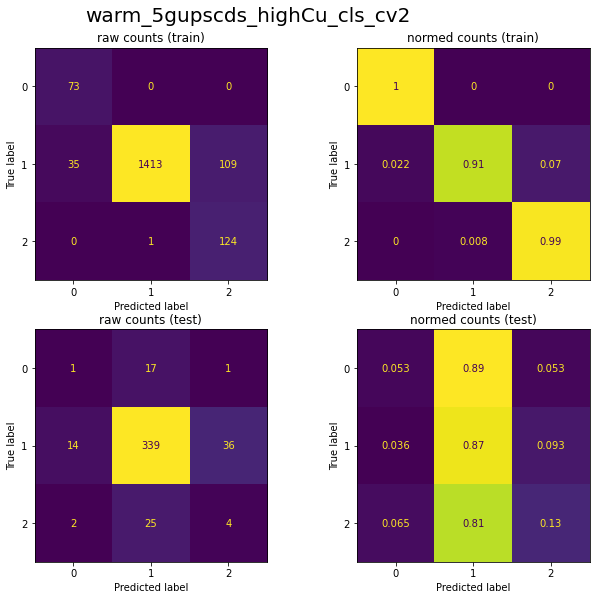

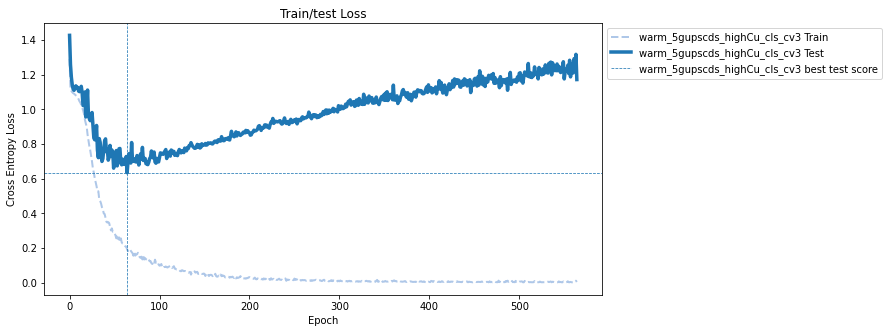

Running predictions for warm_5gupscds_highCu_cls_cv3
___Running CV4___


E:176 | train loss:0.063 | val loss: 0.896:   4%|▎         | 176/5000 [00:13<06:10, 13.02it/s]

EarlyStopping counter: 125 out of 500


E:301 | train loss:0.022 | val loss: 1.080:   6%|▌         | 302/5000 [00:23<06:00, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:426 | train loss:0.010 | val loss: 1.244:   9%|▊         | 426/5000 [00:32<05:51, 13.00it/s]

EarlyStopping counter: 375 out of 500


E:549 | train loss:0.006 | val loss: 1.347:  11%|█         | 549/5000 [00:42<05:43, 12.96it/s]


EarlyStopping counter: 500 out of 500
Early stopping


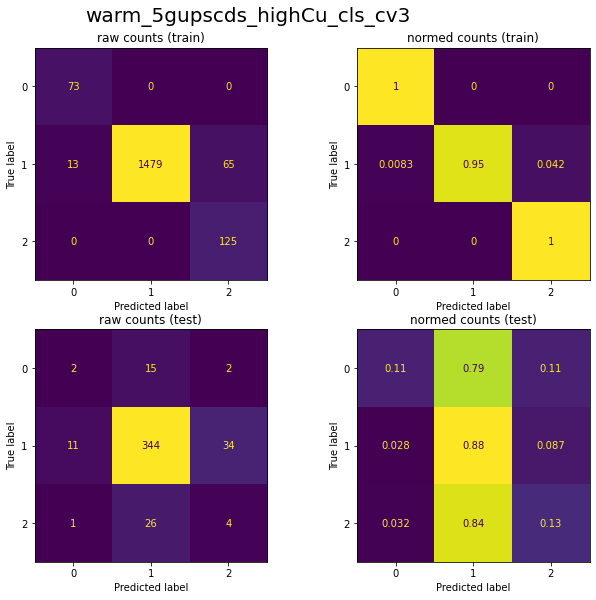

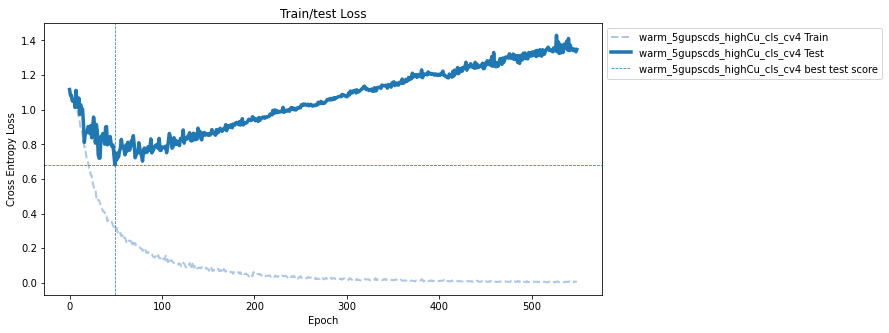

Running predictions for warm_5gupscds_highCu_cls_cv4


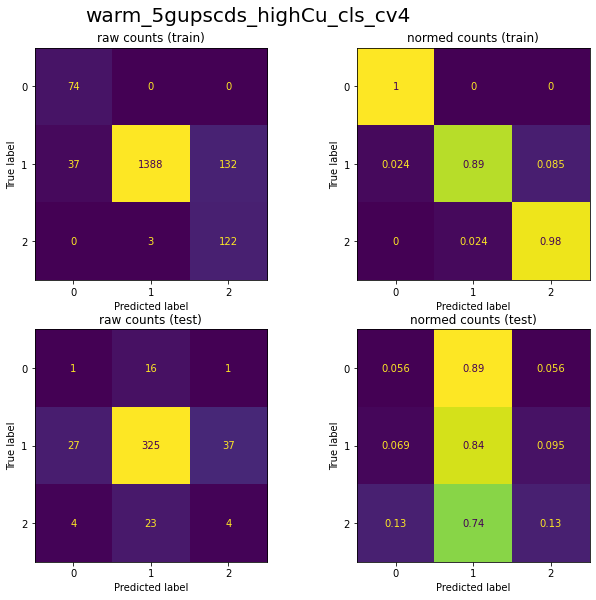

In [36]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### shuffled warm 5g ups cds

___Running CV0___


E:186 | train loss:0.031 | val loss: 0.988:   4%|▎         | 186/5000 [00:14<06:07, 13.10it/s]

EarlyStopping counter: 125 out of 500


E:311 | train loss:0.010 | val loss: 1.205:   6%|▌         | 312/5000 [00:23<05:58, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:436 | train loss:0.005 | val loss: 1.371:   9%|▊         | 436/5000 [00:33<05:47, 13.15it/s]

EarlyStopping counter: 375 out of 500


E:559 | train loss:0.002 | val loss: 1.439:  11%|█         | 559/5000 [00:42<05:40, 13.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


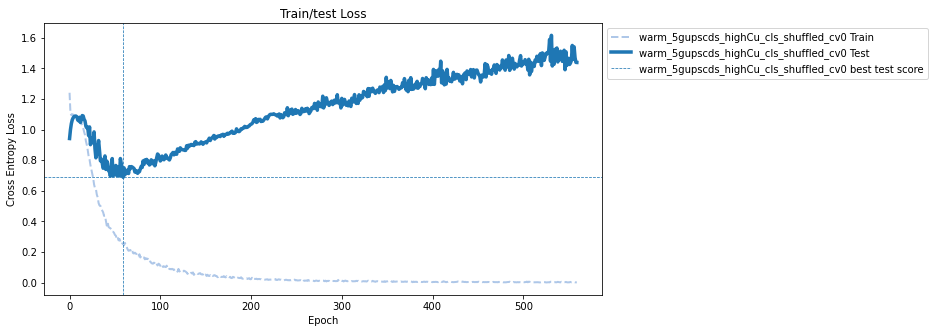

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv0
___Running CV1___


E:169 | train loss:0.025 | val loss: 0.953:   3%|▎         | 170/5000 [00:12<06:05, 13.22it/s]

EarlyStopping counter: 125 out of 500


E:294 | train loss:0.005 | val loss: 1.138:   6%|▌         | 294/5000 [00:22<05:56, 13.19it/s]

EarlyStopping counter: 250 out of 500


E:419 | train loss:0.003 | val loss: 1.283:   8%|▊         | 420/5000 [00:31<05:45, 13.24it/s]

EarlyStopping counter: 375 out of 500


E:542 | train loss:0.001 | val loss: 1.417:  11%|█         | 542/5000 [00:41<05:38, 13.19it/s]


EarlyStopping counter: 500 out of 500
Early stopping


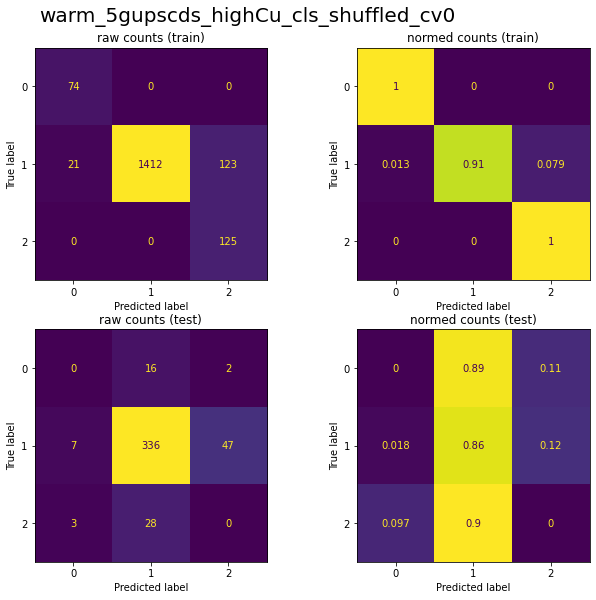

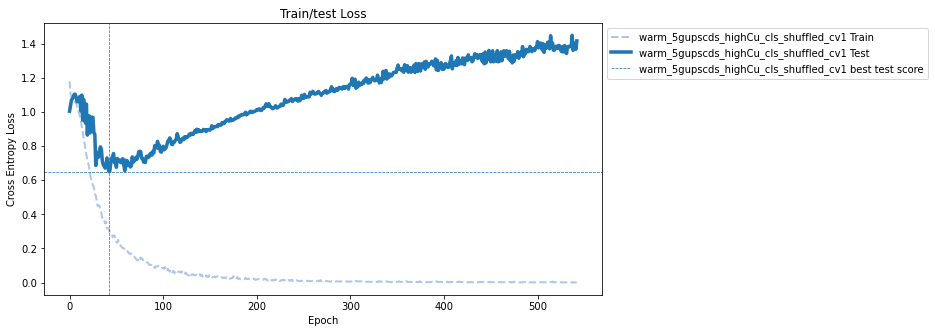

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv1
___Running CV2___


E:186 | train loss:0.035 | val loss: 1.007:   4%|▎         | 186/5000 [00:14<06:09, 13.02it/s]

EarlyStopping counter: 125 out of 500


E:311 | train loss:0.013 | val loss: 1.221:   6%|▌         | 312/5000 [00:24<06:00, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:436 | train loss:0.004 | val loss: 1.416:   9%|▊         | 436/5000 [00:33<05:50, 13.02it/s]

EarlyStopping counter: 375 out of 500


E:559 | train loss:0.003 | val loss: 1.539:  11%|█         | 559/5000 [00:43<05:42, 12.96it/s]


EarlyStopping counter: 500 out of 500
Early stopping


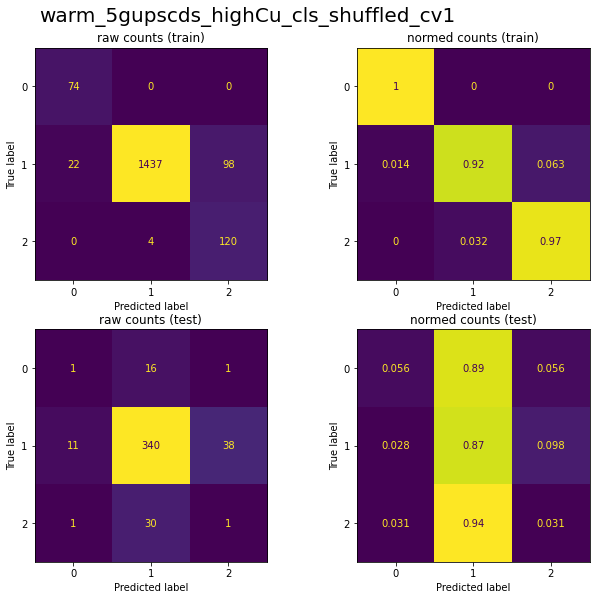

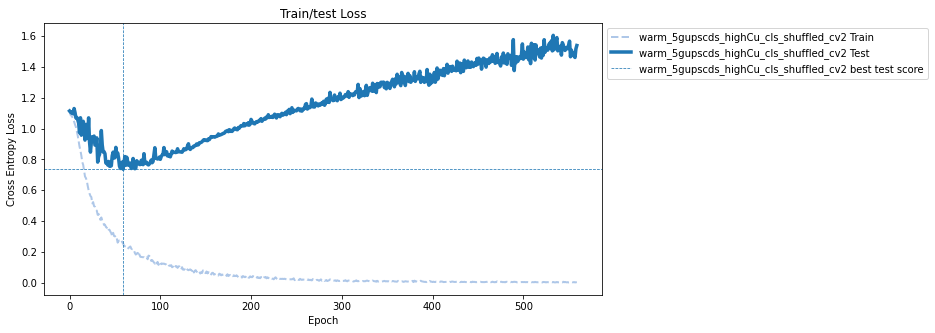

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv2
___Running CV3___


E:195 | train loss:0.035 | val loss: 0.916:   4%|▍         | 195/5000 [00:15<06:03, 13.21it/s]

EarlyStopping counter: 125 out of 500


E:320 | train loss:0.008 | val loss: 1.108:   6%|▋         | 321/5000 [00:24<05:54, 13.20it/s]

EarlyStopping counter: 250 out of 500


E:445 | train loss:0.004 | val loss: 1.241:   9%|▉         | 445/5000 [00:34<05:46, 13.15it/s]

EarlyStopping counter: 375 out of 500


E:568 | train loss:0.003 | val loss: 1.337:  11%|█▏        | 568/5000 [00:43<05:39, 13.07it/s]


EarlyStopping counter: 500 out of 500
Early stopping


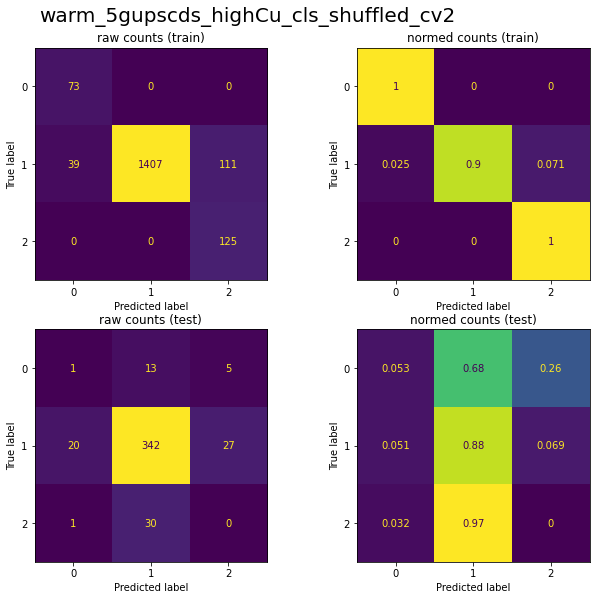

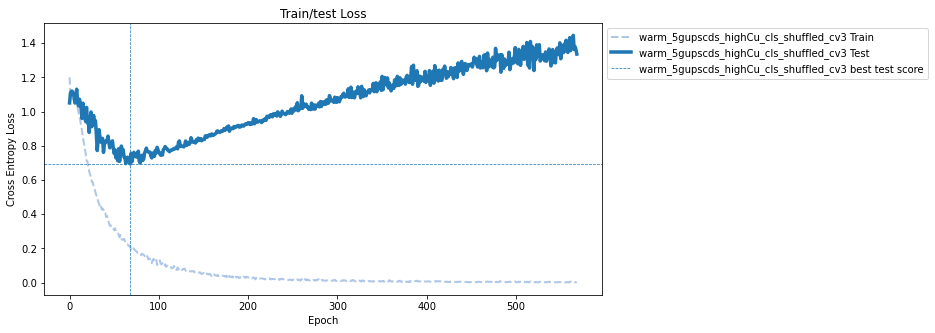

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv3
___Running CV4___


E:170 | train loss:0.039 | val loss: 1.022:   3%|▎         | 170/5000 [00:13<06:08, 13.11it/s]

EarlyStopping counter: 125 out of 500


E:295 | train loss:0.016 | val loss: 1.253:   6%|▌         | 296/5000 [00:22<05:59, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:420 | train loss:0.004 | val loss: 1.385:   8%|▊         | 420/5000 [00:32<05:45, 13.26it/s]

EarlyStopping counter: 375 out of 500


E:543 | train loss:0.002 | val loss: 1.410:  11%|█         | 543/5000 [00:41<05:39, 13.12it/s]


EarlyStopping counter: 500 out of 500
Early stopping


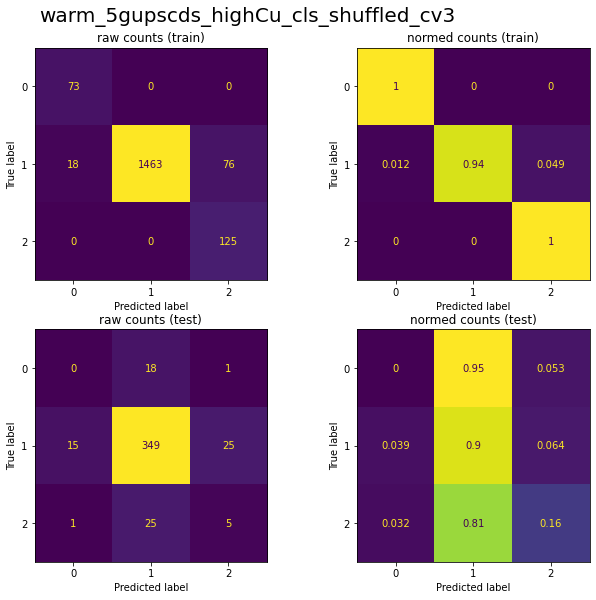

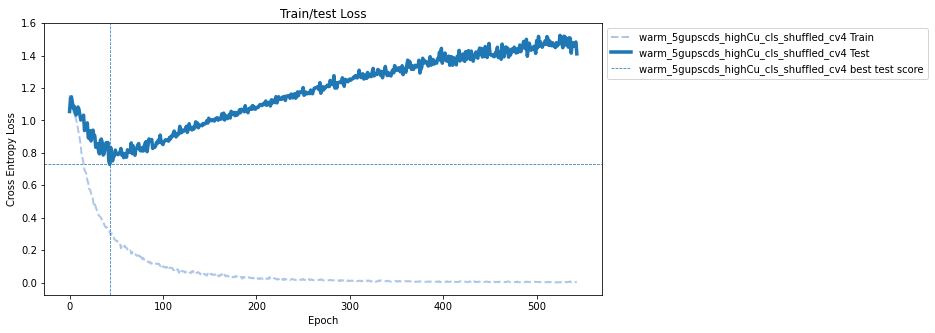

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv4


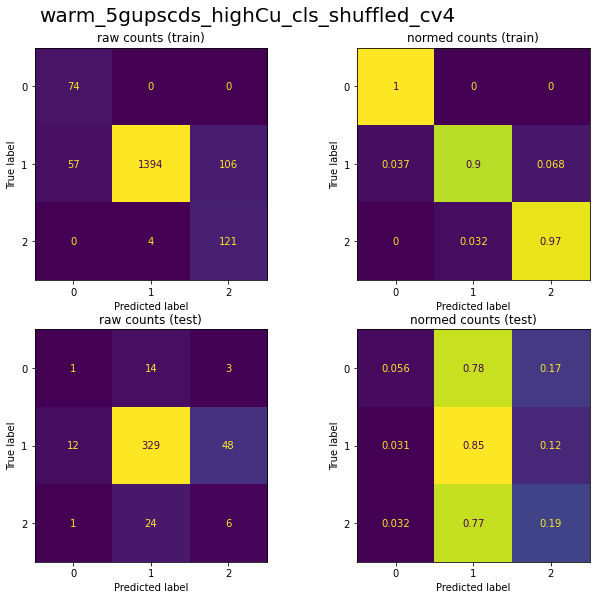

In [37]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### check results from warm ups/cds cls for cu cls

In [38]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

model_name  split  mac_precision  mac_recall  \
0               warm_5org_highCu_cls_cv0  train       0.725889    0.967866   
1               warm_5org_highCu_cls_cv0   test       0.392517    0.405615   
0               warm_5org_highCu_cls_cv1  train       0.848398    0.988011   
1               warm_5org_highCu_cls_cv1   test       0.293631    0.304199   
0               warm_5org_highCu_cls_cv2  train       0.792800    0.979448   
1               warm_5org_highCu_cls_cv2   test       0.357856    0.357898   
0               warm_5org_highCu_cls_cv3  train       0.793096    0.980946   
1               warm_5org_highCu_cls_cv3   test       0.315123    0.313644   
0               warm_5org_highCu_cls_cv4  train       0.806927    0.981160   
1               warm_5org_highCu_cls_cv4   test       0.335878    0.335654   
0      warm_5org_highCu_cls_shuffled_cv0  train       0.876727    0.990360   
1      warm_5org_highCu_cls_shuffled_cv0   test       0.345208    0.348994   
0      warm_5org_highCu_cls_shuffled_cv1  train       0.765640    0.974095   
1      warm_5org_highCu_cls_shuffled_cv1   test       0.319110    0.315005   
0      warm_5org_highCu_cls_shuffled_cv2  train       0.746884    0.954475   
1      warm_5org_highCu_cls_shuffled_cv2   test       0.308106    0.305526   
0      warm_5org_highCu_cls_shuffled_cv3  train       0.886842    0.991008   
1      warm_5org_highCu_cls_shuffled_cv3   test       0.419645    0.373322   
0      warm_5org_highCu_cls_shuffled_cv4  train       0.719791    0.958719   
1      warm_5org_highCu_cls_shuffled_cv4   test       0.316743    0.313708   
0           warm_5gupscds_highCu_cls_cv0  train       0.854874    0.984147   
1           warm_5gupscds_highCu_cls_cv0   test       0.384571    0.397353   
0           warm_5gupscds_highCu_cls_cv1  train       0.716867    0.960893   
1           warm_5gupscds_highCu_cls_cv1   test       0.319810    0.316597   
0           warm_5gupscds_highCu_cls_cv2  train       0.735803    0.966505   
1           warm_5gupscds_highCu_cls_cv2   test       0.348716    0.351043   
0           warm_5gupscds_highCu_cls_cv3  train       0.835577    0.983301   
1           warm_5gupscds_highCu_cls_cv3   test       0.378788    0.372871   
0           warm_5gupscds_highCu_cls_cv4  train       0.714942    0.955819   
1           warm_5gupscds_highCu_cls_cv4   test       0.339782    0.340021   
0  warm_5gupscds_highCu_cls_shuffled_cv0  train       0.760993    0.969152   
1  warm_5gupscds_highCu_cls_shuffled_cv0   test       0.294737    0.287179   
0  warm_5gupscds_highCu_cls_shuffled_cv1  train       0.772839    0.963557   
1  warm_5gupscds_highCu_cls_shuffled_cv1   test       0.327584    0.320281   
0  warm_5gupscds_highCu_cls_shuffled_cv2  train       0.727149    0.967887   
1  warm_5gupscds_highCu_cls_shuffled_cv2   test       0.311255    0.310603   
0  warm_5gupscds_highCu_cls_shuffled_cv3  train       0.808029    0.979876   
1  warm_5gupscds_highCu_cls_shuffled_cv3   test       0.350532    0.352821   
0  warm_5gupscds_highCu_cls_shuffled_cv4  train       0.698355    0.954437   
1  warm_5gupscds_highCu_cls_shuffled_cv4   test       0.357716    0.364954   

     mac_f1  support model_type  seq_mode  fold        task  \
0  0.809602     1755        CNN   regular     0  highCu_cls   
1  0.394811      439        CNN   regular     0  highCu_cls   
0  0.908116     1755        CNN   regular     1  highCu_cls   
1  0.298822      439        CNN   regular     1  highCu_cls   
0  0.866093     1755        CNN   regular     2  highCu_cls   
1  0.357808      439        CNN   regular     2  highCu_cls   
0  0.867738     1755        CNN   regular     3  highCu_cls   
1  0.313704      439        CNN   regular     3  highCu_cls   
0  0.876689     1756        CNN   regular     4  highCu_cls   
1  0.335744      438        CNN   regular     4  highCu_cls   
0  0.927193     1755        CNN  shuffled     0  highCu_cls   
1  0.346926      439        CNN  shuffled     0  highCu_cls   
0  0.842585 

In [39]:
# get predictions from just the 2nd warm start option (ups_cds_cls)
warm2_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'ups' in x])
warm2_preds

model_name  split  mac_precision  mac_recall  \
0           warm_5gupscds_highCu_cls_cv0  train       0.854874    0.984147   
1           warm_5gupscds_highCu_cls_cv0   test       0.384571    0.397353   
0           warm_5gupscds_highCu_cls_cv1  train       0.716867    0.960893   
1           warm_5gupscds_highCu_cls_cv1   test       0.319810    0.316597   
0           warm_5gupscds_highCu_cls_cv2  train       0.735803    0.966505   
1           warm_5gupscds_highCu_cls_cv2   test       0.348716    0.351043   
0           warm_5gupscds_highCu_cls_cv3  train       0.835577    0.983301   
1           warm_5gupscds_highCu_cls_cv3   test       0.378788    0.372871   
0           warm_5gupscds_highCu_cls_cv4  train       0.714942    0.955819   
1           warm_5gupscds_highCu_cls_cv4   test       0.339782    0.340021   
0  warm_5gupscds_highCu_cls_shuffled_cv0  train       0.760993    0.969152   
1  warm_5gupscds_highCu_cls_shuffled_cv0   test       0.294737    0.287179   
0  warm_5gupscds_highCu_cls_shuffled_cv1  train       0.772839    0.963557   
1  warm_5gupscds_highCu_cls_shuffled_cv1   test       0.327584    0.320281   
0  warm_5gupscds_highCu_cls_shuffled_cv2  train       0.727149    0.967887   
1  warm_5gupscds_highCu_cls_shuffled_cv2   test       0.311255    0.310603   
0  warm_5gupscds_highCu_cls_shuffled_cv3  train       0.808029    0.979876   
1  warm_5gupscds_highCu_cls_shuffled_cv3   test       0.350532    0.352821   
0  warm_5gupscds_highCu_cls_shuffled_cv4  train       0.698355    0.954437   
1  warm_5gupscds_highCu_cls_shuffled_cv4   test       0.357716    0.364954   

     mac_f1  support model_type  seq_mode  fold        task  \
0  0.906375     1755        CNN   regular     0  highCu_cls   
1  0.389111      439        CNN   regular     0  highCu_cls   
0  0.802059     1755        CNN   regular     1  highCu_cls   
1  0.317603      439        CNN   regular     1  highCu_cls   
0  0.816854     1755        CNN   regular     2  highCu_cls   
1  0.349062      439        CNN   regular     2  highCu_cls   
0  0.895399     1755        CNN   regular     3  highCu_cls   
1  0.374259      439        CNN   regular     3  highCu_cls   
0  0.795152     1756        CNN   regular     4  highCu_cls   
1  0.337601      438        CNN   regular     4  highCu_cls   
0  0.832488     1755        CNN  shuffled     0  highCu_cls   
1  0.290909      439        CNN  shuffled     0  highCu_cls   
0  0.843661     1755        CNN  shuffled     1  highCu_cls   
1  0.323238      439        CNN  shuffled     1  highCu_cls   
0  0.810368     1755        CNN  shuffled     2  highCu_cls   
1  0.310834      439        CNN  shuffled     2  highCu_cls   
0  0.875330     1755        CNN  shuffled     3  highCu_cls   
1  0.351672      439        CNN  shuffled     3  highCu_cls   
0  0.784312     1756        CNN  shuffled     4  highCu_cls   
1  0.356411      438        CNN  shuffled     4  highCu_cls   

                          start  best_val_score  epoch_stop  total_time  
0  model_5g_ups_cds_cls_weights        0.692545          79   44.851074  
1  model_5g_ups_cds_cls_weights        0.692545          79   44.851074  
0  model_5g_ups_cds_cls_weights        0.679834          44   41.852226  
1  model_5g_ups_cds_cls_weights        0.679834          44   41.852226  
0  model_5g_ups_cds_cls_weights        0.661701          48   41.701480  
1  model_5g_ups_cds_cls_weights        0.661701          48   41.701480  
0  model_5g_ups_cds_cls_weights        0.634382          64   42.978786  
1  model_5g_ups_cds_cls_weights        0.634382          64   42.978786  
0  model_5g_ups_cds_cls_weights        0.682075          49   42.377336  
1  model_5g_ups_cds_cls_weights        0.682075          49   42.377336  
0  model_5g_ups_cds_cls_weights        0.688432          59   42.864223  
1  model_5g_ups_cds_cls_weights        0.688432          59   42.864223  
0  model_5g_ups_cds_cls_weights        0.650150          42   41.109162  
1  model_5g_ups_cds_cls_weights

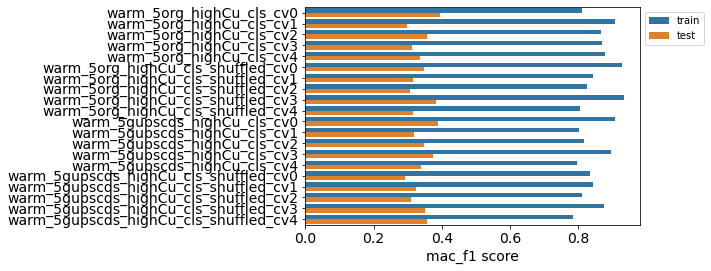

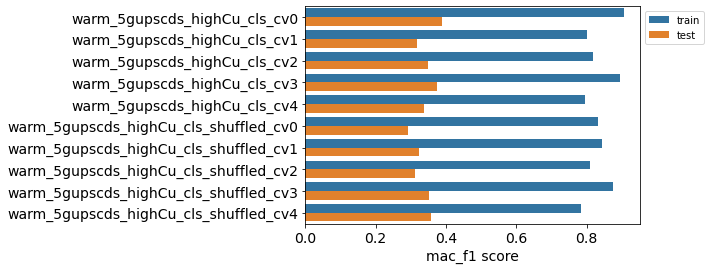

In [40]:
plot_metric(all_preds,'mac_f1')
plot_metric(warm2_preds,'mac_f1')


In [41]:
def check_pred_score_dist(pred_df):
    df_train = pred_df[pred_df['split']=='train']
    df_test = pred_df[pred_df['split']=='test']
    
    # TRAIN plot
    g = sns.catplot(
        data=df_train, x='seq_mode', y='mac_f1',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='mac_f1',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Macro F1 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Train set classification performance",fontsize=20)
    plt.show()
    
    # TEST plot
    g = sns.catplot(
        data=df_test, x='seq_mode', y='mac_f1',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='mac_f1',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Macro F1 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Test set classification performance",fontsize=20)
    plt.show()
    
    
    # t test
    regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
    shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
    print("T-test:",ttest_ind(regular_scores, shuffled_scores))
    print()
    print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
    print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))
    
    

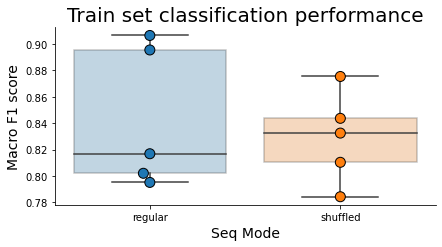

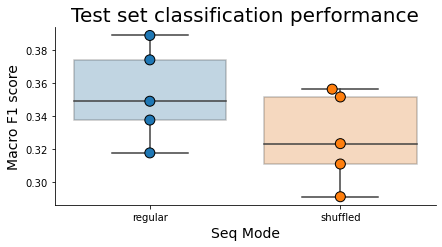

T-test: Ttest_indResult(statistic=1.5151087182514305, pvalue=0.16821052407759848)

Mean Mac F1 for regular seqs: 0.3535272655952637
Mean Mac F1 for shuffled seqs: 0.3266128182697099


In [42]:
check_pred_score_dist(warm2_preds)

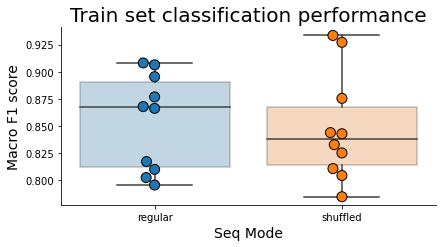

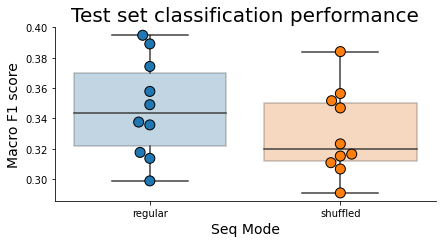

T-test: Ttest_indResult(statistic=1.219674173976244, pvalue=0.23832934964575203)

Mean Mac F1 for regular seqs: 0.3468524848119288
Mean Mac F1 for shuffled seqs: 0.33024140860411366


In [43]:
check_pred_score_dist(all_preds)

## Lastly, try warm start from UPS/CDS classification for the regression task

___Running CV0___


E:181 | train loss:2.406 | val loss: 4.594:   4%|▎         | 182/5000 [00:14<06:07, 13.10it/s]

EarlyStopping counter: 125 out of 500


E:306 | train loss:1.049 | val loss: 4.872:   6%|▌         | 306/5000 [00:23<05:57, 13.13it/s]

EarlyStopping counter: 250 out of 500


E:431 | train loss:0.594 | val loss: 4.800:   9%|▊         | 432/5000 [00:33<05:46, 13.18it/s]

EarlyStopping counter: 375 out of 500


E:554 | train loss:0.432 | val loss: 4.688:  11%|█         | 554/5000 [00:42<05:40, 13.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


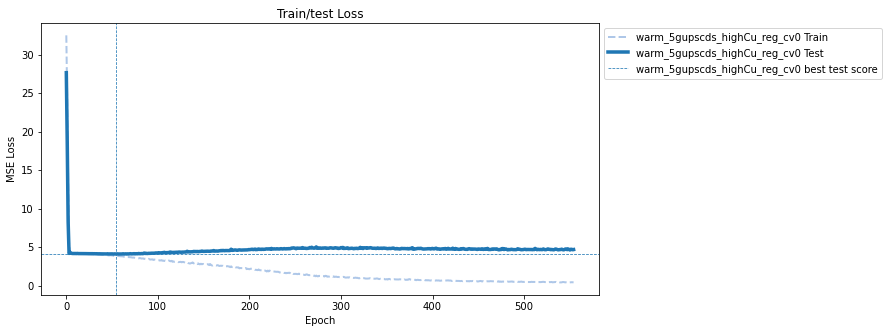

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


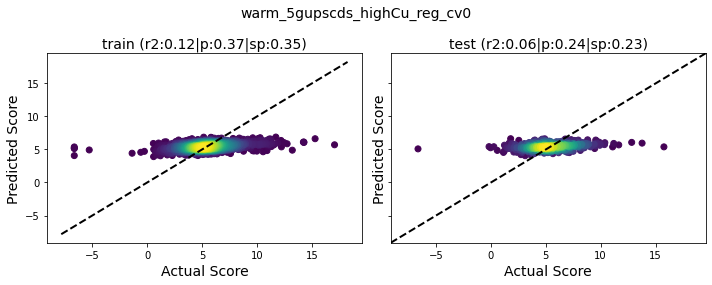

___Running CV1___


E:197 | train loss:2.259 | val loss: 4.860:   4%|▍         | 197/5000 [00:15<06:12, 12.89it/s]

EarlyStopping counter: 125 out of 500


E:322 | train loss:1.049 | val loss: 4.993:   6%|▋         | 323/5000 [00:25<06:01, 12.93it/s]

EarlyStopping counter: 250 out of 500


E:447 | train loss:0.632 | val loss: 4.948:   9%|▉         | 447/5000 [00:35<05:55, 12.81it/s]

EarlyStopping counter: 375 out of 500


E:570 | train loss:0.447 | val loss: 4.674:  11%|█▏        | 570/5000 [00:44<05:47, 12.77it/s]


EarlyStopping counter: 500 out of 500
Early stopping


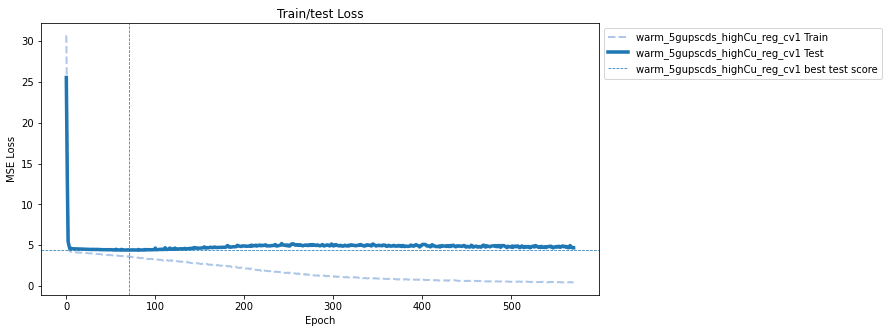

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


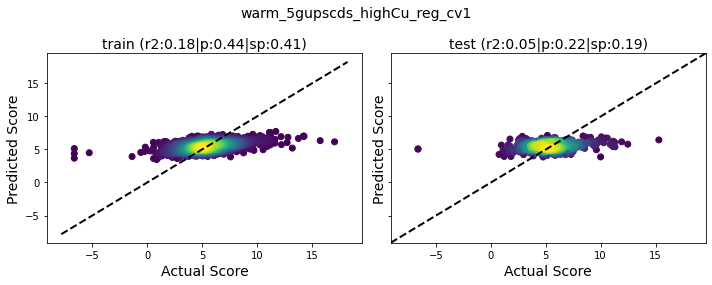

___Running CV2___


E:202 | train loss:2.148 | val loss: 3.761:   4%|▍         | 202/5000 [00:15<06:12, 12.87it/s]

EarlyStopping counter: 125 out of 500


E:327 | train loss:0.820 | val loss: 3.861:   7%|▋         | 328/5000 [00:25<06:00, 12.96it/s]

EarlyStopping counter: 250 out of 500


E:452 | train loss:0.438 | val loss: 3.587:   9%|▉         | 452/5000 [00:35<05:50, 12.96it/s]

EarlyStopping counter: 375 out of 500


E:575 | train loss:0.327 | val loss: 3.466:  12%|█▏        | 575/5000 [00:44<05:45, 12.82it/s]


EarlyStopping counter: 500 out of 500
Early stopping


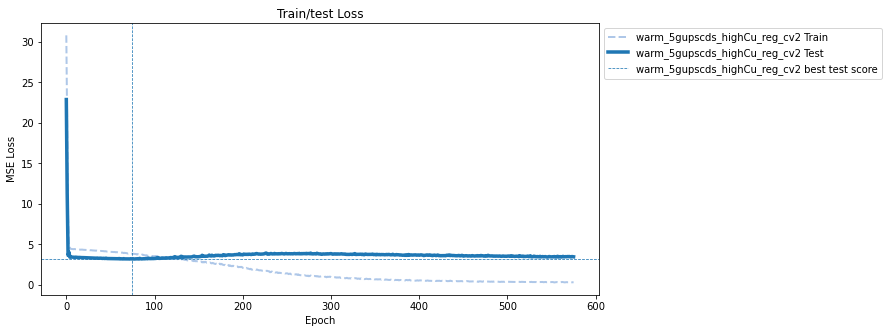

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


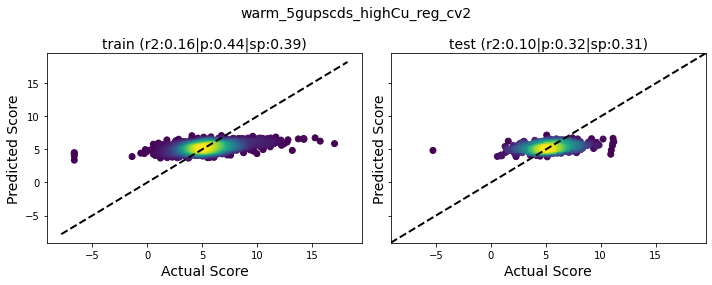

___Running CV3___


E:157 | train loss:2.397 | val loss: 4.689:   3%|▎         | 158/5000 [00:12<06:13, 12.97it/s]

EarlyStopping counter: 125 out of 500


E:282 | train loss:1.132 | val loss: 5.283:   6%|▌         | 282/5000 [00:21<06:04, 12.95it/s]

EarlyStopping counter: 250 out of 500


E:407 | train loss:0.636 | val loss: 5.128:   8%|▊         | 408/5000 [00:31<05:55, 12.90it/s]

EarlyStopping counter: 375 out of 500


E:530 | train loss:0.463 | val loss: 5.172:  11%|█         | 530/5000 [00:41<05:46, 12.88it/s]


EarlyStopping counter: 500 out of 500
Early stopping


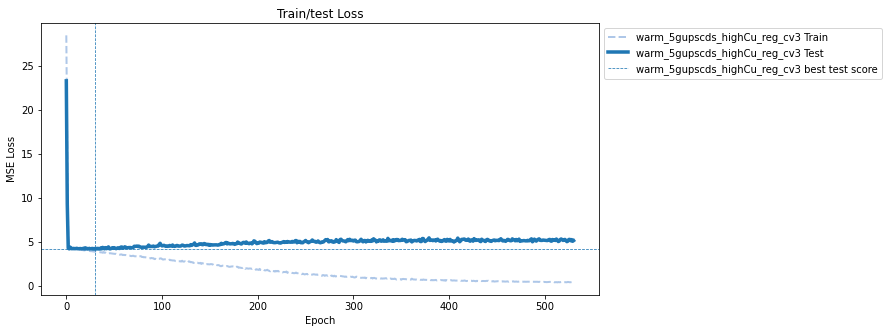

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


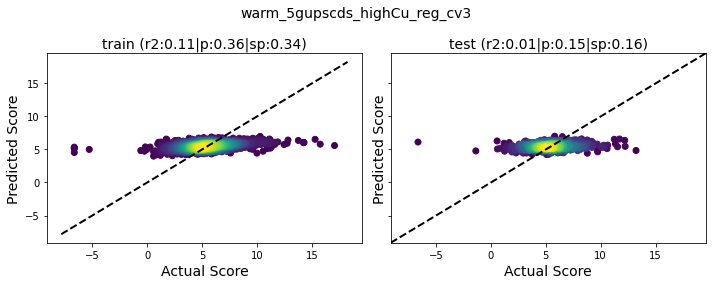

___Running CV4___


E:177 | train loss:2.047 | val loss: 4.972:   4%|▎         | 178/5000 [00:13<06:09, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:302 | train loss:1.110 | val loss: 5.157:   6%|▌         | 302/5000 [00:23<06:01, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:427 | train loss:0.709 | val loss: 5.217:   9%|▊         | 428/5000 [00:33<05:51, 13.00it/s]

EarlyStopping counter: 375 out of 500


E:550 | train loss:0.447 | val loss: 5.117:  11%|█         | 550/5000 [00:42<05:43, 12.95it/s]


EarlyStopping counter: 500 out of 500
Early stopping


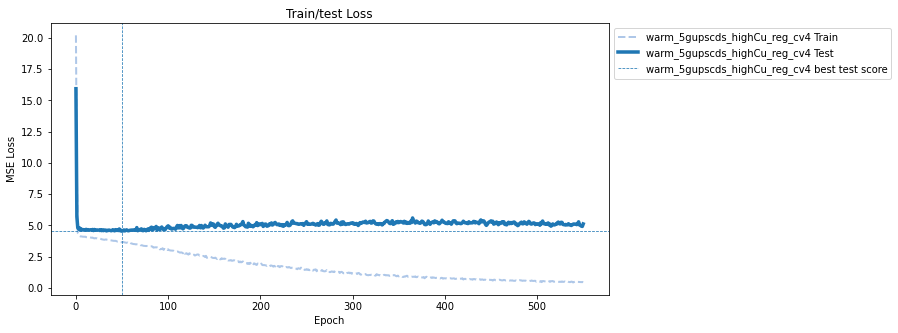

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


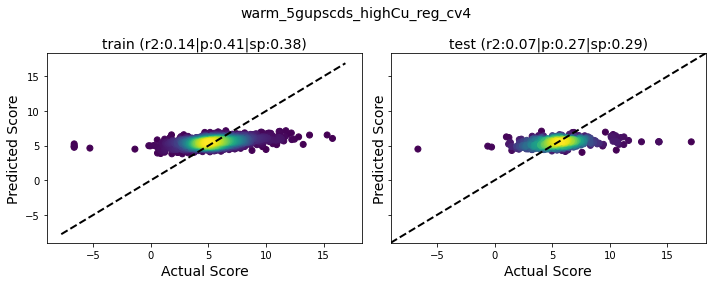

In [44]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'upstream_region'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_reg_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

#### Shuffled warm start ups/cds for regression task

___Running CV0___


E:170 | train loss:3.331 | val loss: 4.690:   3%|▎         | 171/5000 [00:13<06:14, 12.88it/s]

EarlyStopping counter: 125 out of 500


E:295 | train loss:1.603 | val loss: 5.420:   6%|▌         | 295/5000 [00:23<06:05, 12.87it/s]

EarlyStopping counter: 250 out of 500


E:420 | train loss:0.803 | val loss: 5.683:   8%|▊         | 421/5000 [00:32<05:54, 12.91it/s]

EarlyStopping counter: 375 out of 500


E:543 | train loss:0.564 | val loss: 5.683:  11%|█         | 543/5000 [00:42<05:48, 12.79it/s]


EarlyStopping counter: 500 out of 500
Early stopping


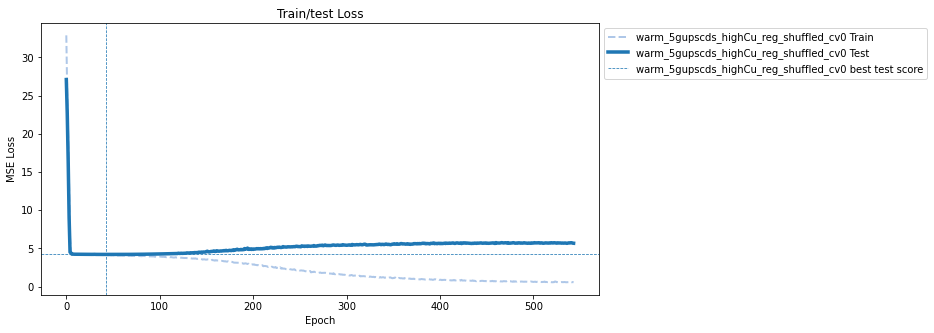

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_shuffled_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv0


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


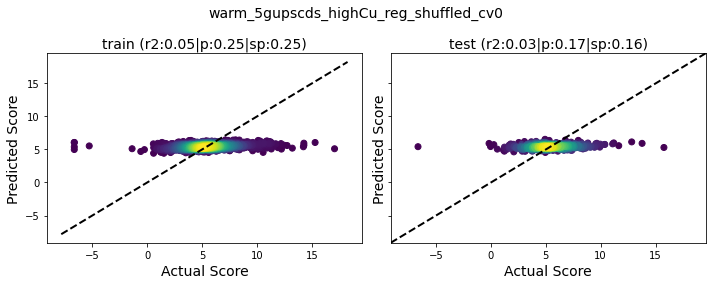

___Running CV1___


E:141 | train loss:2.844 | val loss: 5.180:   3%|▎         | 142/5000 [00:11<06:15, 12.95it/s]

EarlyStopping counter: 125 out of 500


E:266 | train loss:1.588 | val loss: 5.823:   5%|▌         | 266/5000 [00:20<06:04, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:391 | train loss:0.844 | val loss: 5.962:   8%|▊         | 392/5000 [00:30<05:56, 12.93it/s]

EarlyStopping counter: 375 out of 500


E:514 | train loss:0.677 | val loss: 5.918:  10%|█         | 514/5000 [00:39<05:48, 12.86it/s]


EarlyStopping counter: 500 out of 500
Early stopping


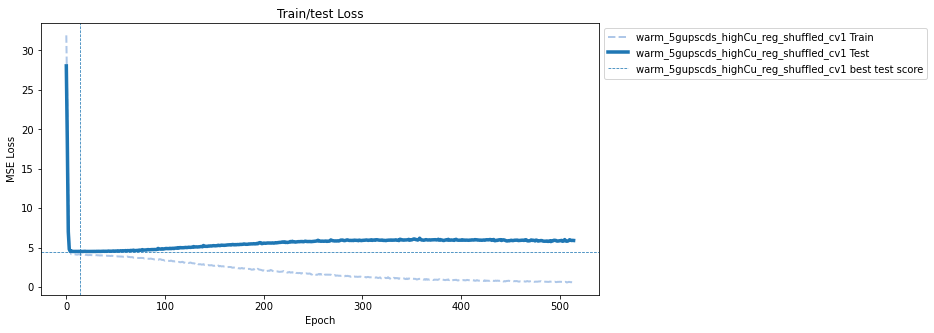

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_shuffled_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv1


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


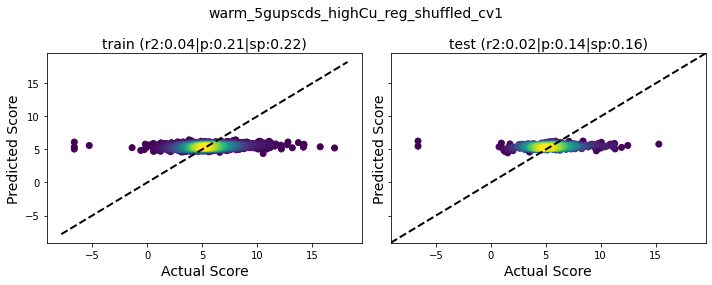

___Running CV2___


E:164 | train loss:2.777 | val loss: 4.342:   3%|▎         | 165/5000 [00:12<06:10, 13.06it/s]

EarlyStopping counter: 125 out of 500


E:289 | train loss:1.297 | val loss: 4.553:   6%|▌         | 289/5000 [00:22<06:04, 12.94it/s]

EarlyStopping counter: 250 out of 500


E:414 | train loss:0.717 | val loss: 4.403:   8%|▊         | 415/5000 [00:32<05:53, 12.95it/s]

EarlyStopping counter: 375 out of 500


E:537 | train loss:0.457 | val loss: 4.291:  11%|█         | 537/5000 [00:41<05:45, 12.91it/s]


EarlyStopping counter: 500 out of 500
Early stopping


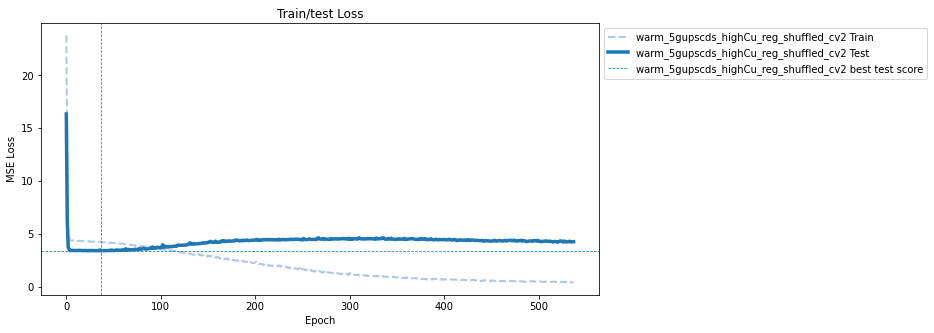

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_shuffled_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv2


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


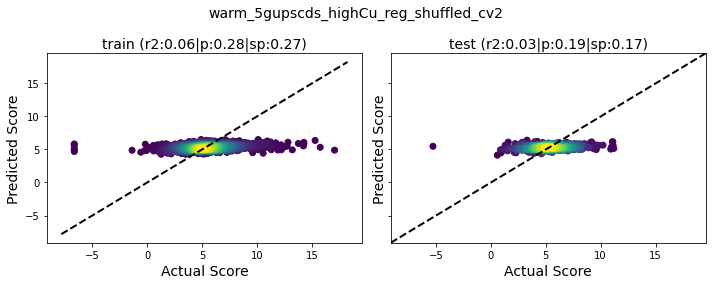

___Running CV3___


E:172 | train loss:2.569 | val loss: 5.161:   3%|▎         | 173/5000 [00:13<06:09, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:297 | train loss:1.159 | val loss: 5.750:   6%|▌         | 297/5000 [00:23<06:00, 13.04it/s]

EarlyStopping counter: 250 out of 500


E:422 | train loss:0.654 | val loss: 5.694:   8%|▊         | 423/5000 [00:32<05:50, 13.04it/s]

EarlyStopping counter: 375 out of 500


E:545 | train loss:0.509 | val loss: 5.303:  11%|█         | 545/5000 [00:42<05:43, 12.97it/s]


EarlyStopping counter: 500 out of 500
Early stopping


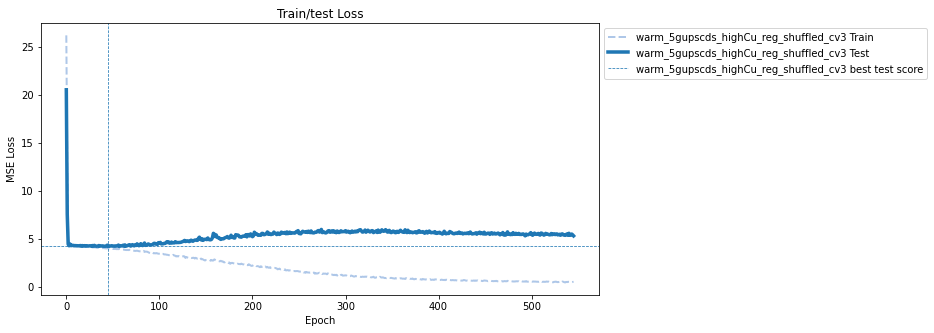

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_shuffled_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv3


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


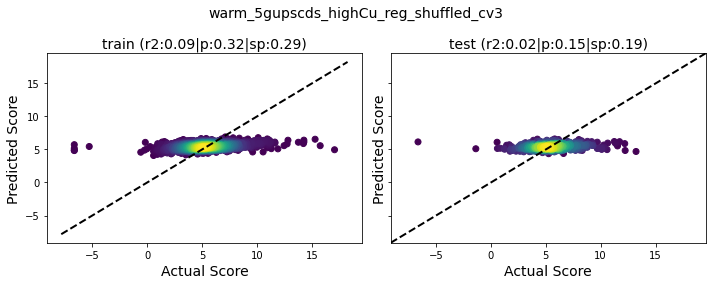

___Running CV4___


E:184 | train loss:2.378 | val loss: 5.416:   4%|▎         | 185/5000 [00:14<06:08, 13.07it/s]

EarlyStopping counter: 125 out of 500


E:309 | train loss:1.061 | val loss: 5.798:   6%|▌         | 309/5000 [00:23<05:57, 13.13it/s]

EarlyStopping counter: 250 out of 500


E:434 | train loss:0.581 | val loss: 5.574:   9%|▊         | 435/5000 [00:33<05:47, 13.12it/s]

EarlyStopping counter: 375 out of 500


E:557 | train loss:0.422 | val loss: 5.589:  11%|█         | 557/5000 [00:42<05:41, 13.02it/s]


EarlyStopping counter: 500 out of 500
Early stopping


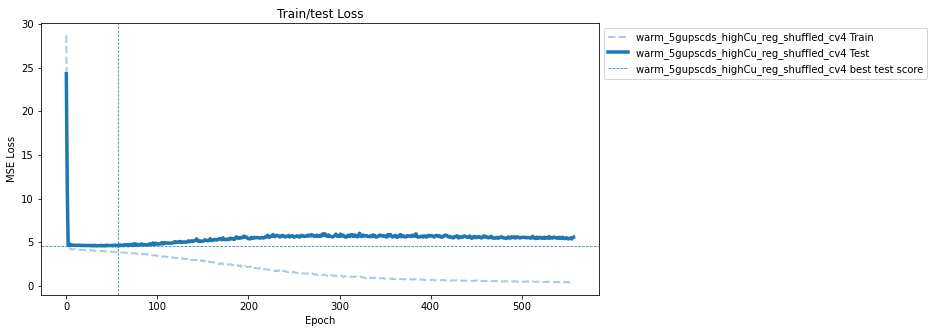

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for warm_5gupscds_highCu_reg_shuffled_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv4


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


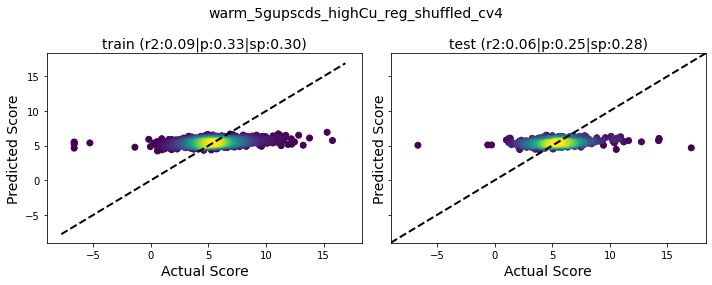

In [45]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'shuffled_seq'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_reg_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

In [46]:
all_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr])
all_preds_regr

model_name  split        r2   pearson  spearman  \
0               warm_5org_highCu_reg_cv0  train  0.145859  0.409594  0.379183   
1               warm_5org_highCu_reg_cv0   test  0.052195  0.229713  0.220709   
0               warm_5org_highCu_reg_cv1  train  0.330154  0.621326  0.554501   
1               warm_5org_highCu_reg_cv1   test  0.051342  0.252938  0.160876   
0               warm_5org_highCu_reg_cv2  train  0.162496  0.440514  0.387737   
1               warm_5org_highCu_reg_cv2   test  0.067611  0.263854  0.269337   
0               warm_5org_highCu_reg_cv3  train  0.087045  0.310455  0.306270   
1               warm_5org_highCu_reg_cv3   test -0.020327  0.100886  0.113511   
0               warm_5org_highCu_reg_cv4  train  0.138703  0.406890  0.373681   
1               warm_5org_highCu_reg_cv4   test  0.071179  0.287709  0.272393   
0      warm_5org_highCu_reg_shuffled_cv0  train  0.050683  0.236340  0.228432   
1      warm_5org_highCu_reg_shuffled_cv0   test  0.014976  0.143158  0.138367   
0      warm_5org_highCu_reg_shuffled_cv1  train  0.015880  0.139027  0.125963   
1      warm_5org_highCu_reg_shuffled_cv1   test -0.004050  0.068310  0.072173   
0      warm_5org_highCu_reg_shuffled_cv2  train  0.087772  0.324808  0.289976   
1      warm_5org_highCu_reg_shuffled_cv2   test  0.024957  0.178186  0.182511   
0      warm_5org_highCu_reg_shuffled_cv3  train  0.048706  0.225544  0.203991   
1      warm_5org_highCu_reg_shuffled_cv3   test -0.000693  0.127854  0.149048   
0      warm_5org_highCu_reg_shuffled_cv4  train  0.130672  0.397702  0.360354   
1      warm_5org_highCu_reg_shuffled_cv4   test  0.050465  0.238638  0.259934   
0           warm_5gupscds_highCu_reg_cv0  train  0.118306  0.369058  0.346214   
1           warm_5gupscds_highCu_reg_cv0   test  0.055261  0.235186  0.232697   
0           warm_5gupscds_highCu_reg_cv1  train  0.178711  0.439111  0.405880   
1           warm_5gupscds_highCu_reg_cv1   test  0.045527  0.224149  0.185374   
0           warm_5gupscds_highCu_reg_cv2  train  0.161257  0.439120  0.394944   
1           warm_5gupscds_highCu_reg_cv2   test  0.102497  0.321042  0.313497   
0           warm_5gupscds_highCu_reg_cv3  train  0.112587  0.355793  0.339350   
1           warm_5gupscds_highCu_reg_cv3   test  0.012186  0.147614  0.155089   
0           warm_5gupscds_highCu_reg_cv4  train  0.144151  0.405260  0.378237   
1           warm_5gupscds_highCu_reg_cv4   test  0.067312  0.265960  0.287957   
0  warm_5gupscds_highCu_reg_shuffled_cv0  train  0.053276  0.246474  0.251969   
1  warm_5gupscds_highCu_reg_shuffled_cv0   test  0.029627  0.172948  0.157518   
0  warm_5gupscds_highCu_reg_shuffled_cv1  train  0.038988  0.207218  0.217238   
1  warm_5gupscds_highCu_reg_shuffled_cv1   test  0.019299  0.139650  0.158707   
0  warm_5gupscds_highCu_reg_shuffled_cv2  train  0.058044  0.278375  0.265747   
1  warm_5gupscds_highCu_reg_shuffled_cv2   test  0.034561  0.186024  0.169975   
0  warm_5gupscds_highCu_reg_shuffled_cv3  train  0.090337  0.321920  0.292249   
1  warm_5gupscds_highCu_reg_shuffled_cv3   test  0.016395  0.151852  0.188875   
0  warm_5gupscds_highCu_reg_shuffled_cv4  train  0.089782  0.331900  0.300604   
1  warm_5gupscds_highCu_reg_shuffled_cv4   test  0.058973  0.254130  0.277869   

  model_type  seq_mode  fold                task  \
0        CNN   regular     0  highCu_logTPM_regr   
1        CNN   regular     0  highCu_logTPM_regr   
0        CNN   regular     1  highCu_logTPM_regr   
1        CNN   regular     1  highCu_logTPM_regr   
0        CNN   regular     2  highCu_logTPM_regr   
1        CNN   regular     2  highCu_logTPM_regr   
0        CNN   regular     3  highCu_logTPM_regr   
1        CNN   regular     3  highCu_logTPM_regr   
0        CNN   regular     4  highCu_logTPM_regr   
1        CNN   regular     4  highCu_logTPM_regr   
0        CNN  shuffled     0  highCu_logTPM_regr   
1        CNN  shuffled     0  highCu_logTPM_regr   
0        CNN  shuffled     1  hi

In [47]:
# get predictions from just the 2nd warm start option (ups_cds_cls)
warm2_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr if 'ups' in x])
warm2_preds_regr

model_name  split        r2   pearson  spearman  \
0           warm_5gupscds_highCu_reg_cv0  train  0.118306  0.369058  0.346214   
1           warm_5gupscds_highCu_reg_cv0   test  0.055261  0.235186  0.232697   
0           warm_5gupscds_highCu_reg_cv1  train  0.178711  0.439111  0.405880   
1           warm_5gupscds_highCu_reg_cv1   test  0.045527  0.224149  0.185374   
0           warm_5gupscds_highCu_reg_cv2  train  0.161257  0.439120  0.394944   
1           warm_5gupscds_highCu_reg_cv2   test  0.102497  0.321042  0.313497   
0           warm_5gupscds_highCu_reg_cv3  train  0.112587  0.355793  0.339350   
1           warm_5gupscds_highCu_reg_cv3   test  0.012186  0.147614  0.155089   
0           warm_5gupscds_highCu_reg_cv4  train  0.144151  0.405260  0.378237   
1           warm_5gupscds_highCu_reg_cv4   test  0.067312  0.265960  0.287957   
0  warm_5gupscds_highCu_reg_shuffled_cv0  train  0.053276  0.246474  0.251969   
1  warm_5gupscds_highCu_reg_shuffled_cv0   test  0.029627  0.172948  0.157518   
0  warm_5gupscds_highCu_reg_shuffled_cv1  train  0.038988  0.207218  0.217238   
1  warm_5gupscds_highCu_reg_shuffled_cv1   test  0.019299  0.139650  0.158707   
0  warm_5gupscds_highCu_reg_shuffled_cv2  train  0.058044  0.278375  0.265747   
1  warm_5gupscds_highCu_reg_shuffled_cv2   test  0.034561  0.186024  0.169975   
0  warm_5gupscds_highCu_reg_shuffled_cv3  train  0.090337  0.321920  0.292249   
1  warm_5gupscds_highCu_reg_shuffled_cv3   test  0.016395  0.151852  0.188875   
0  warm_5gupscds_highCu_reg_shuffled_cv4  train  0.089782  0.331900  0.300604   
1  warm_5gupscds_highCu_reg_shuffled_cv4   test  0.058973  0.254130  0.277869   

  model_type  seq_mode  fold                task  \
0        CNN   regular     0  highCu_logTPM_regr   
1        CNN   regular     0  highCu_logTPM_regr   
0        CNN   regular     1  highCu_logTPM_regr   
1        CNN   regular     1  highCu_logTPM_regr   
0        CNN   regular     2  highCu_logTPM_regr   
1        CNN   regular     2  highCu_logTPM_regr   
0        CNN   regular     3  highCu_logTPM_regr   
1        CNN   regular     3  highCu_logTPM_regr   
0        CNN   regular     4  highCu_logTPM_regr   
1        CNN   regular     4  highCu_logTPM_regr   
0        CNN  shuffled     0  highCu_logTPM_regr   
1        CNN  shuffled     0  highCu_logTPM_regr   
0        CNN  shuffled     1  highCu_logTPM_regr   
1        CNN  shuffled     1  highCu_logTPM_regr   
0        CNN  shuffled     2  highCu_logTPM_regr   
1        CNN  shuffled     2  highCu_logTPM_regr   
0        CNN  shuffled     3  highCu_logTPM_regr   
1        CNN  shuffled     3  highCu_logTPM_regr   
0        CNN  shuffled     4  highCu_logTPM_regr   
1        CNN  shuffled     4  highCu_logTPM_regr   

                          start  best_val_score  epoch_stop  total_time  
0  model_5g_ups_cds_cls_weights        4.107084          54   42.473484  
1  model_5g_ups_cds_cls_weights        4.107084          54   42.473484  
0  model_5g_ups_cds_cls_weights        4.400111          70   44.652374  
1  model_5g_ups_cds_cls_weights        4.400111          70   44.652374  
0  model_5g_ups_cds_cls_weights        3.194081          75   44.856185  
1  model_5g_ups_cds_cls_weights        3.194081          75   44.856185  
0  model_5g_ups_cds_cls_weights        4.216802          30   41.146884  
1  model_5g_ups_cds_cls_weights        4.216802          30   41.146884  
0  model_5g_ups_cds_cls_weights        4.542751          50   42.458759  
1  model_5g_ups_cds_cls_weights        4.542751          50   42.458759  
0  model_5g_ups_cds_cls_weights        4.218525          43   42.444087  
1  model_5g_ups_cds_cls_weights        4.218525          43   42.444087  
0  model_5g_ups_cds_cls_weights        4.521020          14   39.960767  
1  model_5g_ups_cds_cls_weights        4.521020          14   39.960767  
0  model_5g_ups_cds_cls_weights        3.435854          37   41.599737  
1  model_5g_ups_cds_cls_weights        3.435854    

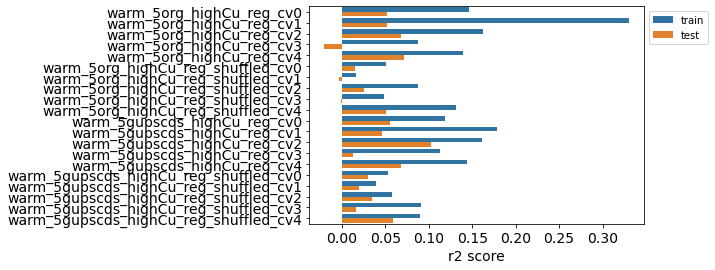

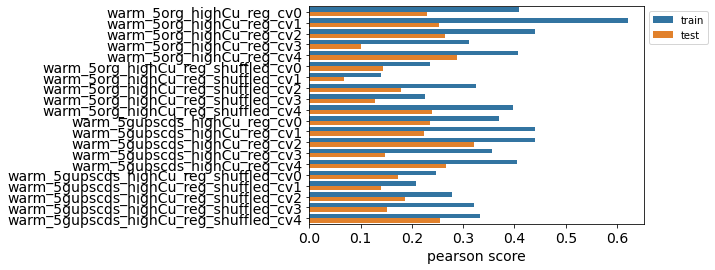

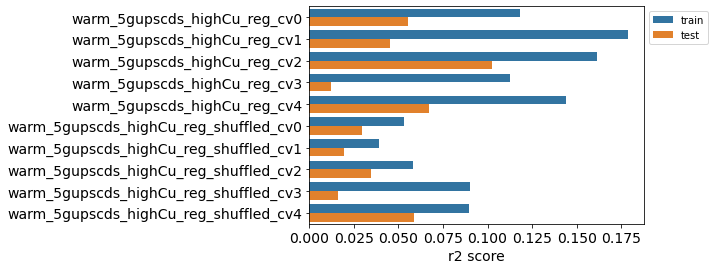

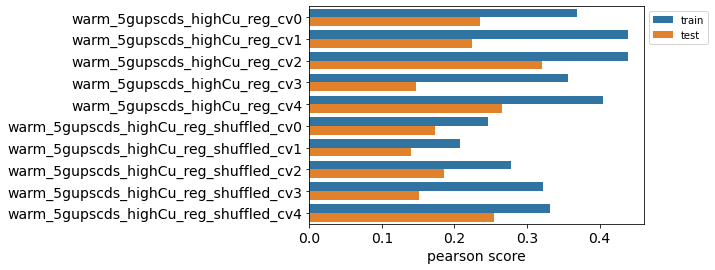

In [48]:
plot_metric(all_preds_regr,'r2')
plot_metric(all_preds_regr,'pearson')

plot_metric(warm2_preds_regr,'r2')
plot_metric(warm2_preds_regr,'pearson')

In [49]:
def check_pred_score_dist_reg(pred_df):
    df_train = pred_df[pred_df['split']=='train']
    df_test = pred_df[pred_df['split']=='test']
    
    # TRAIN plot
    g = sns.catplot(
        data=df_train, x='seq_mode', y='r2',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='r2',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('R2 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Train set classification performance",fontsize=20)
    plt.show()
    
    g = sns.catplot(
        data=df_train, x='seq_mode', y='pearson',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='pearson',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Pearson score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Train set classification performance",fontsize=20)
    plt.show()
    
    # TEST plot
    g = sns.catplot(
        data=df_test, x='seq_mode', y='r2',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='r2',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('R2 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Test set classification performance",fontsize=20)
    plt.show()
    
    # TEST plot
    g = sns.catplot(
        data=df_test, x='seq_mode', y='pearson',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='pearson',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Pearson score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Test set classification performance",fontsize=20)
    plt.show()
    
    
    # t test
    regular_scores = df_test[df_test['seq_mode']=='regular']['r2'].values
    shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['r2'].values
    print("T-test:",ttest_ind(regular_scores, shuffled_scores))
    print()
    print("Mean R2 for regular seqs:",np.mean(regular_scores))
    print("Mean R2 for shuffled seqs:",np.mean(shuffled_scores))
    print()
    
    regular_scores = df_test[df_test['seq_mode']=='regular']['pearson'].values
    shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['pearson'].values
    print("T-test:",ttest_ind(regular_scores, shuffled_scores))
    print()
    print("Mean pearson for regular seqs:",np.mean(regular_scores))
    print("Mean pearson for shuffled seqs:",np.mean(shuffled_scores))
    

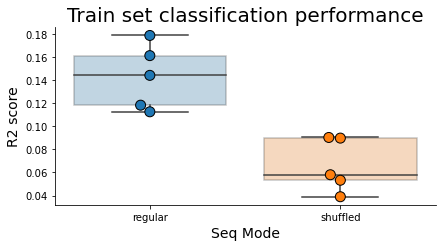

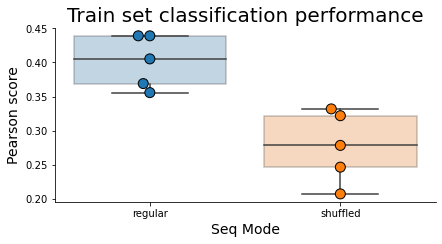

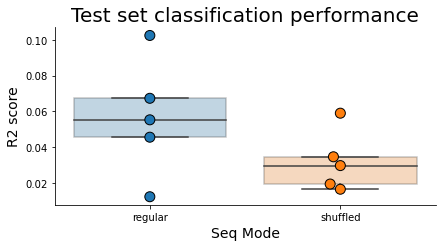

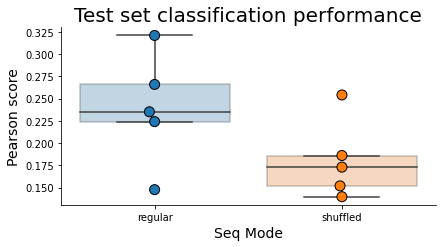

T-test: Ttest_indResult(statistic=1.4997278385880117, pvalue=0.17207230878102614)

Mean R2 for regular seqs: 0.05655670245731115
Mean R2 for shuffled seqs: 0.03177130432539432

T-test: Ttest_indResult(statistic=1.6691146715634337, pvalue=0.1336463315360838)

Mean pearson for regular seqs: 0.23879039102436797
Mean pearson for shuffled seqs: 0.18092068547052312


In [50]:
check_pred_score_dist_reg(warm2_preds_regr)

In [51]:
all_preds.to_csv('out_warmStart_highCu_cls/all_pred_res.tsv',sep='\t',index=False)
all_preds_regr.to_csv('out_warmStart_highCu_regr/all_pred_res.tsv',sep='\t',index=False)


In [52]:
print("done!")

done!


In [53]:
all_preds

model_name  split  mac_precision  mac_recall  \
0               warm_5org_highCu_cls_cv0  train       0.725889    0.967866   
1               warm_5org_highCu_cls_cv0   test       0.392517    0.405615   
0               warm_5org_highCu_cls_cv1  train       0.848398    0.988011   
1               warm_5org_highCu_cls_cv1   test       0.293631    0.304199   
0               warm_5org_highCu_cls_cv2  train       0.792800    0.979448   
1               warm_5org_highCu_cls_cv2   test       0.357856    0.357898   
0               warm_5org_highCu_cls_cv3  train       0.793096    0.980946   
1               warm_5org_highCu_cls_cv3   test       0.315123    0.313644   
0               warm_5org_highCu_cls_cv4  train       0.806927    0.981160   
1               warm_5org_highCu_cls_cv4   test       0.335878    0.335654   
0      warm_5org_highCu_cls_shuffled_cv0  train       0.876727    0.990360   
1      warm_5org_highCu_cls_shuffled_cv0   test       0.345208    0.348994   
0      warm_5org_highCu_cls_shuffled_cv1  train       0.765640    0.974095   
1      warm_5org_highCu_cls_shuffled_cv1   test       0.319110    0.315005   
0      warm_5org_highCu_cls_shuffled_cv2  train       0.746884    0.954475   
1      warm_5org_highCu_cls_shuffled_cv2   test       0.308106    0.305526   
0      warm_5org_highCu_cls_shuffled_cv3  train       0.886842    0.991008   
1      warm_5org_highCu_cls_shuffled_cv3   test       0.419645    0.373322   
0      warm_5org_highCu_cls_shuffled_cv4  train       0.719791    0.958719   
1      warm_5org_highCu_cls_shuffled_cv4   test       0.316743    0.313708   
0           warm_5gupscds_highCu_cls_cv0  train       0.854874    0.984147   
1           warm_5gupscds_highCu_cls_cv0   test       0.384571    0.397353   
0           warm_5gupscds_highCu_cls_cv1  train       0.716867    0.960893   
1           warm_5gupscds_highCu_cls_cv1   test       0.319810    0.316597   
0           warm_5gupscds_highCu_cls_cv2  train       0.735803    0.966505   
1           warm_5gupscds_highCu_cls_cv2   test       0.348716    0.351043   
0           warm_5gupscds_highCu_cls_cv3  train       0.835577    0.983301   
1           warm_5gupscds_highCu_cls_cv3   test       0.378788    0.372871   
0           warm_5gupscds_highCu_cls_cv4  train       0.714942    0.955819   
1           warm_5gupscds_highCu_cls_cv4   test       0.339782    0.340021   
0  warm_5gupscds_highCu_cls_shuffled_cv0  train       0.760993    0.969152   
1  warm_5gupscds_highCu_cls_shuffled_cv0   test       0.294737    0.287179   
0  warm_5gupscds_highCu_cls_shuffled_cv1  train       0.772839    0.963557   
1  warm_5gupscds_highCu_cls_shuffled_cv1   test       0.327584    0.320281   
0  warm_5gupscds_highCu_cls_shuffled_cv2  train       0.727149    0.967887   
1  warm_5gupscds_highCu_cls_shuffled_cv2   test       0.311255    0.310603   
0  warm_5gupscds_highCu_cls_shuffled_cv3  train       0.808029    0.979876   
1  warm_5gupscds_highCu_cls_shuffled_cv3   test       0.350532    0.352821   
0  warm_5gupscds_highCu_cls_shuffled_cv4  train       0.698355    0.954437   
1  warm_5gupscds_highCu_cls_shuffled_cv4   test       0.357716    0.364954   

     mac_f1  support model_type  seq_mode  fold        task  \
0  0.809602     1755        CNN   regular     0  highCu_cls   
1  0.394811      439        CNN   regular     0  highCu_cls   
0  0.908116     1755        CNN   regular     1  highCu_cls   
1  0.298822      439        CNN   regular     1  highCu_cls   
0  0.866093     1755        CNN   regular     2  highCu_cls   
1  0.357808      439        CNN   regular     2  highCu_cls   
0  0.867738     1755        CNN   regular     3  highCu_cls   
1  0.313704      439        CNN   regular     3  highCu_cls   
0  0.876689     1756        CNN   regular     4  highCu_cls   
1  0.335744      438        CNN   regular     4  highCu_cls   
0  0.927193     1755        CNN  shuffled     0  highCu_cls   
1  0.346926      439        CNN  shuffled     0  highCu_cls   
0  0.842585 